### Food Cost Predictive Modeling: Prophet

Overview:
- Model Selection
    1. This predictive modeling will use Facebook Prophet to forecast product prices
    2. Prophet was selected as it is compatible with multiple regressors (e.g. holidays, company sale promotions) when predicting its target variable.
- Prepare data for making predictions
    1. Define time-series column as 'ds' and target columns (price) as 'y' so that Prophet will recognize the correct values
    2. Define training dataset as records from 1995 - 2020
    3. Define validation dataset as records from 2021 - 2022
- Perform predictions using Prophet
    1. Create metric for measuring the accuracy of each model (WMAPE)
    2. Define seasonality parameters
    3. Iterate through unique products contained in the training dataset to make predictions
- Visualize predictions
    1. Plot predicted and actual values over time
    2. Compare predicted values to validation values using WMAPE to generate overall percent error for each product's prediction.

#### Preparing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stats_can import StatsCan
sc = StatsCan(data_folder='../data_sources/raw_data/')

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
national_df = pd.read_csv('../data_sources/clean_data/national_MRA_clean.csv')

In [3]:
# rename columns to contain the 'ds' and 'y' column names required by Prophet
national_df_renamed = national_df.rename(columns={'date':'ds', 'price':'y'})

national_df_renamed

,ds,location,vectorid,y,product,unit_quantity,unit,category
0,1995-01-01,Canada,v735165,10.17,Round steak,1.0,kilogram,Protein
1,1995-01-01,Canada,v735176,11.25,Sirloin steak,1.0,kilogram,Protein
2,1995-01-01,Canada,v735187,12.08,Prime rib roast,1.0,kilogram,Protein
3,1995-01-01,Canada,v735198,7.23,Blade roast,1.0,kilogram,Protein
4,1995-01-01,Canada,v735209,7.12,Stewing beef,1.0,kilogram,Protein
...,...,...,...,...,...,...,...,...
15649,2022-02-01,Canada,v735202,7.10,"Coffee, instant",200.0,grams,Beverages
15650,2022-02-01,Canada,v735203,4.49,Tea,72.0,bags,Beverages
15651,2022-02-01,Canada,v735204,4.45,Cooking or salad oil,1.0,litre,Oils
15652,2022-02-01,Canada,v735205,1.28,"Soup, canned",284.0,millilitres,Other_foods


In [4]:
# cast 'ds' column to datetime
national_df_renamed['ds'] = pd.to_datetime(national_df_renamed['ds'])
national_df_renamed.dtypes

ds               datetime64[ns]
location                 object
vectorid                 object
y                       float64
product                  object
unit_quantity           float64
unit                     object
category                 object
dtype: object

In [5]:
# define training and validation sets
train = national_df_renamed.loc[national_df_renamed['ds'].dt.year <= 2016]
valid = national_df_renamed.loc[(national_df_renamed['ds'].dt.year > 2016)]

In [6]:
train

,ds,location,vectorid,y,product,unit_quantity,unit,category
0,1995-01-01,Canada,v735165,10.17,Round steak,1.0,kilogram,Protein
1,1995-01-01,Canada,v735176,11.25,Sirloin steak,1.0,kilogram,Protein
2,1995-01-01,Canada,v735187,12.08,Prime rib roast,1.0,kilogram,Protein
3,1995-01-01,Canada,v735198,7.23,Blade roast,1.0,kilogram,Protein
4,1995-01-01,Canada,v735209,7.12,Stewing beef,1.0,kilogram,Protein
...,...,...,...,...,...,...,...,...
15047,2020-12-01,Canada,v735202,6.74,"Coffee, instant",200.0,grams,Beverages
15048,2020-12-01,Canada,v735203,4.21,Tea,72.0,bags,Beverages
15049,2020-12-01,Canada,v735204,3.04,Cooking or salad oil,1.0,litre,Oils
15050,2020-12-01,Canada,v735205,1.29,"Soup, canned",284.0,millilitres,Other_foods


In [7]:
train.dtypes

ds               datetime64[ns]
location                 object
vectorid                 object
y                       float64
product                  object
unit_quantity           float64
unit                     object
category                 object
dtype: object

In [8]:
valid

,ds,location,vectorid,y,product,unit_quantity,unit,category
15052,2021-01-01,Canada,v735165,17.81,Round steak,1.0,kilogram,Protein
15053,2021-01-01,Canada,v735176,22.68,Sirloin steak,1.0,kilogram,Protein
15054,2021-01-01,Canada,v735187,37.66,Prime rib roast,1.0,kilogram,Protein
15055,2021-01-01,Canada,v735198,16.25,Blade roast,1.0,kilogram,Protein
15056,2021-01-01,Canada,v735209,15.88,Stewing beef,1.0,kilogram,Protein
...,...,...,...,...,...,...,...,...
15649,2022-02-01,Canada,v735202,7.10,"Coffee, instant",200.0,grams,Beverages
15650,2022-02-01,Canada,v735203,4.49,Tea,72.0,bags,Beverages
15651,2022-02-01,Canada,v735204,4.45,Cooking or salad oil,1.0,litre,Oils
15652,2022-02-01,Canada,v735205,1.28,"Soup, canned",284.0,millilitres,Other_foods


In [9]:
valid.dtypes

ds               datetime64[ns]
location                 object
vectorid                 object
y                       float64
product                  object
unit_quantity           float64
unit                     object
category                 object
dtype: object

#### Make Predictions

Prophet terminology:
- ds: date used for predictions
- y: predicted value
- yhat: midpoint of prediction interval (the most likely value for the forecast)
- yhat_lower: lower bound of the prediction interval
- yhat_upper: upper bound of the prediction interval

Resource used to carry out this modeling step: https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/ 

In [10]:
# create a means to measure the model's performance

# use WMAPE (weighted mean absolute percentage error), where the absolutes of the actual values are the weights
def wmape(y_true, y_pred):
    # suppress division by zero error
    np.seterr(divide='ignore', invalid='ignore')
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [ ]:
# # import Prophet and train it on time series data for each product
# from prophet import Prophet 

# # create a list to store each prediction
# p = list()

# # iterate through unique product values to create a prediction for each product
# for product in train['product'].unique():
#     print('product:', product)
#     # create datasets that contain only the rows from the original training and validation datasets that correspond with the current product being forecasted
#     train_ = train.loc[train['product'] == product]
#     valid_ = valid.loc[valid['product'] == product]

#     # create a Prophet object m with seasonality parameters
#     m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
#     # train the model with the product-specific training data
#     m.fit(train_)

#     # create a new dataframe that will contain the dates for the next 24 months after the end of the {train_} dataset
#     future = m.make_future_dataframe(periods = 24, freq= 'M', include_history=False)
#     # create new columns containing only month and year values to permit accurate joins
#     #   values of 'ds' in {future} are the last day of the month
#     #   values of 'ds' in the {valid_} dataframe are the first day of the month
#     future['yyyy_mm'] = pd.to_datetime(future['ds']).dt.strftime('%Y-%m')
#     valid_['yyyy_mm'] = pd.to_datetime(valid_['ds']).dt.strftime('%Y-%m')
#     # drop old 'ds' columns
#     future.drop(columns=['ds'], inplace=True)
#     valid_.drop(columns=['ds'], inplace=True)
#     # rename new 'yyyy_mm' columns to 'ds'
#     future.rename(columns={'yyyy_mm':'ds'}, inplace=True)
#     valid_.rename(columns={'yyyy_mm':'ds'}, inplace=True)
#     # merge future data with valid_ data
#     future = future.merge(valid_[['ds','product', 'y']], on=['ds'], how='left')
    
#     # create a dataframe to contain the predicted values for each date in the {future} dataframe
#     forecast = m.predict(future)
#     # add a 'product' column to the {forecast} dataframe containing predicted values
#     # this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
#     forecast['product'] = product
#     # append the product prediction to the list of stored predictions
#     p.append(forecast[['ds', 'yhat', 'product', 'yhat_upper', 'yhat_lower']])

# # concatenate all dataframes within the list 
# print('concatenating all product dataframes...')
# p = pd.concat(p, ignore_index=True)
# # clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
# p['yhat'] = p['yhat'].clip(lower=0)
# # create new 'yyyy_mm' column for {valid} dataframe
# valid['yyyy_mm'] = pd.to_datetime(valid['ds']).dt.strftime('%Y-%m')
# # drop old 'ds' column
# valid.drop(columns=['ds'], inplace=True)
# # rename new 'yyyy_mm' column to 'ds'
# valid.rename(columns={'yyyy_mm':'ds'}, inplace=True)
# # convert {valid} 'ds' column to datetime
# valid['ds'] = pd.to_datetime(valid['ds'])
# # merge prediction {p} dataframe with validation {valid} dataframe to compare values 
# p = p.merge(valid, on=['ds', 'product'], how='left')
# # calculate performance
# wmape(p['y'], p['yhat'])

In [41]:
# import Prophet and train it on time series data for each product
from prophet import Prophet 
from prophet.diagnostics import cross_validation

# create a list to store each prediction
p = list()

# iterate through unique product values to create a prediction for each product
for product in train['product'].unique():
    print('product:', product)
    # create datasets that contain only the rows from the original training and validation datasets that correspond with the current product being forecasted
    train_ = train.loc[train['product'] == product]
    valid_ = valid.loc[valid['product'] == product]

    # create a Prophet object m with seasonality parameters
    m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
    # train the model with the product-specific training data
    m.fit(train_)
    # create a cross validations dataframe
    df_cv = cross_validation(m, initial='1825 days' period='91 days', horizon = '182 days')
    print(df_cv.head())

    # create a new dataframe that will contain the dates for the next 24 months after the end of the {train_} dataset
    future = m.make_future_dataframe(periods = 3, freq= 'M', include_history=False)
    # create new columns containing only month and year values to permit accurate joins
    #   values of 'ds' in {future} are the last day of the month
    #   values of 'ds' in the {valid_} dataframe are the first day of the month
    future['yyyy_mm'] = pd.to_datetime(future['ds']).dt.strftime('%Y-%m')
    valid_['yyyy_mm'] = pd.to_datetime(valid_['ds']).dt.strftime('%Y-%m')
    # drop old 'ds' columns
    future.drop(columns=['ds'], inplace=True)
    valid_.drop(columns=['ds'], inplace=True)
    # rename new 'yyyy_mm' columns to 'ds'
    future.rename(columns={'yyyy_mm':'ds'}, inplace=True)
    valid_.rename(columns={'yyyy_mm':'ds'}, inplace=True)
    # merge future data with valid_ data
    future = future.merge(valid_[['ds','product', 'y']], on=['ds'], how='left')
    
    # create a dataframe to contain the predicted values for each date in the {future} dataframe
    forecast = m.predict(future)
    # add a 'product' column to the {forecast} dataframe containing predicted values
    # this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
    forecast['product'] = product
    # append the product prediction to the list of stored predictions
    p.append(forecast[['ds', 'yhat', 'product', 'yhat_upper', 'yhat_lower']])


# concatenate all dataframes within the list 
print('concatenating all product dataframes...')
p = pd.concat(p, ignore_index=True)
# clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
p['yhat'] = p['yhat'].clip(lower=0)
# create new 'yyyy_mm' column for {valid} dataframe
valid['yyyy_mm'] = pd.to_datetime(valid['ds']).dt.strftime('%Y-%m')
# drop old 'ds' column
valid.drop(columns=['ds'], inplace=True)
# rename new 'yyyy_mm' column to 'ds'
valid.rename(columns={'yyyy_mm':'ds'}, inplace=True)
# convert {valid} 'ds' column to datetime
valid['ds'] = pd.to_datetime(valid['ds'])
# merge prediction {p} dataframe with validation {valid} dataframe to compare values 
p = p.merge(valid, on=['ds', 'product'], how='left')
# calculate performance
wmape(p['y'], p['yhat'])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3526427356.py, line 20)

In [34]:
# import Prophet and train it on time series data for each product
from prophet import Prophet 
from prophet.diagnostics import cross_validation

# create a list to store each prediction
p = list()

# iterate through unique product values to create a prediction for each product
for product in train['product'].unique():
    print('product:', product)
    # create datasets that contain only the rows from the original training and validation datasets that correspond with the current product being forecasted
    train_ = train.loc[train['product'] == product]
    valid_ = valid.loc[valid['product'] == product]

    # create a Prophet object m with seasonality parameters
    m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
    # train the model with the product-specific training data
    m.fit(train_)
    # create a cross validations dataframe
    df_cv = cross_validation(m, initial='1825 days' period='91 days', horizon = '182 days')
    print(df_cv.head())

    # create a new dataframe that will contain the dates for the next 24 months after the end of the {train_} dataset
    future = m.make_future_dataframe(periods = 3, freq= 'M', include_history=False)
    # create new columns containing only month and year values to permit accurate joins
    #   values of 'ds' in {future} are the last day of the month
    #   values of 'ds' in the {valid_} dataframe are the first day of the month
    future['yyyy_mm'] = pd.to_datetime(future['ds']).dt.strftime('%Y-%m')
    valid_['yyyy_mm'] = pd.to_datetime(valid_['ds']).dt.strftime('%Y-%m')
    # drop old 'ds' columns
    future.drop(columns=['ds'], inplace=True)
    valid_.drop(columns=['ds'], inplace=True)
    # rename new 'yyyy_mm' columns to 'ds'
    future.rename(columns={'yyyy_mm':'ds'}, inplace=True)
    valid_.rename(columns={'yyyy_mm':'ds'}, inplace=True)
    # merge future data with valid_ data
    future = future.merge(valid_[['ds','product', 'y']], on=['ds'], how='left')
    
    # create a dataframe to contain the predicted values for each date in the {future} dataframe
    forecast = m.predict(future)
    # add a 'product' column to the {forecast} dataframe containing predicted values
    # this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
    forecast['product'] = product
    # append the product prediction to the list of stored predictions
    p.append(forecast[['ds', 'yhat', 'product', 'yhat_upper', 'yhat_lower']])


# concatenate all dataframes within the list 
print('concatenating all product dataframes...')
p = pd.concat(p, ignore_index=True)
# clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
p['yhat'] = p['yhat'].clip(lower=0)
# create new 'yyyy_mm' column for {valid} dataframe
valid['yyyy_mm'] = pd.to_datetime(valid['ds']).dt.strftime('%Y-%m')
# drop old 'ds' column
valid.drop(columns=['ds'], inplace=True)
# rename new 'yyyy_mm' column to 'ds'
valid.rename(columns={'yyyy_mm':'ds'}, inplace=True)
# convert {valid} 'ds' column to datetime
valid['ds'] = pd.to_datetime(valid['ds'])
# merge prediction {p} dataframe with validation {valid} dataframe to compare values 
p = p.merge(valid, on=['ds', 'product'], how='left')
# calculate performance
wmape(p['y'], p['yhat'])

13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing


product: Round steak


  0%|          | 0/97 [00:00<?, ?it/s]

13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1] done processing
13:13:51 - cmdstanpy - INFO - Chain [1] start processing
13:13:59 - cmdstanpy - INFO - Chain [1] done processing
13:13:59 - cmdstanpy - INFO - Chain [1] start processing
13:14:08 - cmdstanpy - INFO - Chain [1] done processing
13:14:08 - cmdstanpy - INFO - Chain [1] start processing
13:14:19 - cmdstanpy - INFO - Chain [1] done processing
13:14:19 - cmdstanpy - INFO - Chain [1] start processing
13:14:19 - cmdstanpy - INFO - Chain [1] done processing
13:14:19 - cmdstanpy - INFO - Chain [1] start processing
13:14:20 - cmdstanpy - INFO - Chain [1] done processing
13:14:20 - cmdstanpy - INFO - Chain [1] start processing
13:14:20 - cmdstanpy - INFO - Chain [1] done processing
13:14:20 - cmdstanpy - INFO - Chain [1] start processing
13:14:20 - cmdstanpy - INFO - Chain [1] done processing
13:14:20 - cmdstanpy - INFO - Chain [1] start processing
13:14:21 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  12.122251   12.120700   12.124247  9.37 1996-07-02
1 1996-09-01   6.871591    6.866303    6.877816  9.32 1996-07-02
2 1996-10-01   8.815192    8.805100    8.826583  9.53 1996-07-02
3 1996-11-01   9.893152    9.877204    9.911320  9.18 1996-07-02
4 1996-12-01  10.840350   10.815980   10.866334  9.66 1996-07-02
product: Sirloin steak


  0%|          | 0/97 [00:00<?, ?it/s]

13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] done processing
13:14:47 - cmdstanpy - INFO - Chain [1] start processing
13:14:55 - cmdstanpy - INFO - Chain [1] done processing
13:14:55 - cmdstanpy - INFO - Chain [1] start processing
13:15:04 - cmdstanpy - INFO - Chain [1] done processing
13:15:04 - cmdstanpy - INFO - Chain [1] start processing
13:15:15 - cmdstanpy - INFO - Chain [1] done processing
13:15:15 - cmdstanpy - INFO - Chain [1] start processing
13:15:27 - cmdstanpy - INFO - Chain [1] done processing
13:15:27 - cmdstanpy - INFO - Chain [1] start processing
13:15:27 - cmdstanpy - INFO - Chain [1] done processing
13:15:27 - cmdstanpy - INFO - Chain [1] start processing
13:15:28 - cmdstanpy - INFO - Chain [1] done processing
13:15:28 - cmdstanpy - INFO - Chain [1] start processing
13:15:28 - cmdstanpy - INFO - Chain [1] done processing
13:15:28 - cmdstanpy - INFO - Chain [1] start processing
13:15:28 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 1996-08-01  14.300896   14.299675   14.302072  10.74 1996-07-02
1 1996-09-01  22.931602   22.927297   22.935640  10.25 1996-07-02
2 1996-10-01  -5.115407   -5.123313   -5.107740  10.54 1996-07-02
3 1996-11-01  11.713528   11.701248   11.725715  10.51 1996-07-02
4 1996-12-01  17.216281   17.198576   17.232873  10.52 1996-07-02
product: Prime rib roast


  0%|          | 0/97 [00:00<?, ?it/s]

13:15:47 - cmdstanpy - INFO - Chain [1] start processing
13:15:54 - cmdstanpy - INFO - Chain [1] done processing
13:15:54 - cmdstanpy - INFO - Chain [1] start processing
13:15:59 - cmdstanpy - INFO - Chain [1] done processing
13:15:59 - cmdstanpy - INFO - Chain [1] start processing
13:16:08 - cmdstanpy - INFO - Chain [1] done processing
13:16:09 - cmdstanpy - INFO - Chain [1] start processing
13:16:19 - cmdstanpy - INFO - Chain [1] done processing
13:16:19 - cmdstanpy - INFO - Chain [1] start processing
13:16:19 - cmdstanpy - INFO - Chain [1] done processing
13:16:20 - cmdstanpy - INFO - Chain [1] start processing
13:16:20 - cmdstanpy - INFO - Chain [1] done processing
13:16:20 - cmdstanpy - INFO - Chain [1] start processing
13:16:20 - cmdstanpy - INFO - Chain [1] done processing
13:16:20 - cmdstanpy - INFO - Chain [1] start processing
13:16:20 - cmdstanpy - INFO - Chain [1] done processing
13:16:21 - cmdstanpy - INFO - Chain [1] start processing
13:16:21 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 1996-08-01  10.980345   10.977918   10.983199  11.70 1996-07-02
1 1996-09-01  18.869343   18.861539   18.877960  11.96 1996-07-02
2 1996-10-01   3.504997    3.489516    3.521630  11.66 1996-07-02
3 1996-11-01  15.244928   15.221037   15.271758  11.41 1996-07-02
4 1996-12-01   9.849001    9.814567    9.886719  11.66 1996-07-02
product: Blade roast


  0%|          | 0/97 [00:00<?, ?it/s]

13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:48 - cmdstanpy - INFO - Chain [1] done processing
13:16:48 - cmdstanpy - INFO - Chain [1] start processing
13:16:56 - cmdstanpy - INFO - Chain [1] done processing
13:16:56 - cmdstanpy - INFO - Chain [1] start processing
13:17:05 - cmdstanpy - INFO - Chain [1] done processing
13:17:05 - cmdstanpy - INFO - Chain [1] start processing
13:17:16 - cmdstanpy - INFO - Chain [1] done processing
13:17:16 - cmdstanpy - INFO - Chain [1] start processing
13:17:16 - cmdstanpy - INFO - Chain [1] done processing
13:17:16 - cmdstanpy - INFO - Chain [1] start processing
13:17:16 - cmdstanpy - INFO - Chain [1] done processing
13:17:17 - cmdstanpy - INFO - Chain [1] start processing
13:17:17 - cmdstanpy - INFO - Chain [1] done processing
13:17:17 - cmdstanpy - INFO - Chain [1] start processing
13:17:17 - cmdstanpy - INFO - Chain [1] done processing
13:17:17 - cmdstanpy - INFO - Chain [1] start processing
13:17:17 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  4.115715    4.114060    4.117294  5.97 1996-07-02
1 1996-09-01  8.385229    8.380135    8.390487  6.19 1996-07-02
2 1996-10-01  3.383891    3.373912    3.394052  6.35 1996-07-02
3 1996-11-01  7.903771    7.888910    7.918783  6.35 1996-07-02
4 1996-12-01  6.668931    6.648150    6.689837  6.41 1996-07-02
product: Stewing beef


  0%|          | 0/97 [00:00<?, ?it/s]

13:17:37 - cmdstanpy - INFO - Chain [1] start processing
13:17:44 - cmdstanpy - INFO - Chain [1] done processing
13:17:44 - cmdstanpy - INFO - Chain [1] start processing
13:17:53 - cmdstanpy - INFO - Chain [1] done processing
13:17:53 - cmdstanpy - INFO - Chain [1] start processing
13:18:02 - cmdstanpy - INFO - Chain [1] done processing
13:18:02 - cmdstanpy - INFO - Chain [1] start processing
13:18:13 - cmdstanpy - INFO - Chain [1] done processing
13:18:13 - cmdstanpy - INFO - Chain [1] start processing
13:18:13 - cmdstanpy - INFO - Chain [1] done processing
13:18:14 - cmdstanpy - INFO - Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing
13:18:14 - cmdstanpy - INFO - Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing
13:18:14 - cmdstanpy - INFO - Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1] done processing
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  -4.371340   -4.388344   -4.355809  6.62 1996-07-02
1 1996-09-01  15.763008   15.708696   15.813148  6.56 1996-07-02
2 1996-10-01  -2.997448   -3.095509   -2.893942  6.67 1996-07-02
3 1996-11-01  19.100723   18.946554   19.262268  6.48 1996-07-02
4 1996-12-01  -8.632562   -8.851673   -8.412857  6.83 1996-07-02
product: Ground beef


  0%|          | 0/97 [00:00<?, ?it/s]

13:18:34 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing
13:18:42 - cmdstanpy - INFO - Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing
13:18:51 - cmdstanpy - INFO - Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing
13:19:00 - cmdstanpy - INFO - Chain [1] start processing
13:19:10 - cmdstanpy - INFO - Chain [1] done processing
13:19:10 - cmdstanpy - INFO - Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
13:19:12 - cmdstanpy - INFO - Chain [1] done processing
13:19:12 - cmdstanpy - INFO - Chain [1] start processing
13:19:12 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  5.066533    5.065283    5.067806  3.56 1996-07-02
1 1996-09-01  3.455983    3.452114    3.460128  3.59 1996-07-02
2 1996-10-01  2.796088    2.788272    2.804148  3.63 1996-07-02
3 1996-11-01  3.687209    3.674846    3.700046  3.72 1996-07-02
4 1996-12-01  5.092519    5.074249    5.111237  3.70 1996-07-02
product: Pork chops


  0%|          | 0/97 [00:00<?, ?it/s]

13:19:32 - cmdstanpy - INFO - Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing
13:19:39 - cmdstanpy - INFO - Chain [1] start processing
13:19:48 - cmdstanpy - INFO - Chain [1] done processing
13:19:48 - cmdstanpy - INFO - Chain [1] start processing
13:19:57 - cmdstanpy - INFO - Chain [1] done processing
13:19:57 - cmdstanpy - INFO - Chain [1] start processing
13:19:57 - cmdstanpy - INFO - Chain [1] done processing
13:19:57 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing
13:19:59 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  15.002313   14.958349   15.047789  9.66 1996-07-02
1 1996-09-01  15.388831   15.237858   15.529067  9.40 1996-07-02
2 1996-10-01  16.415378   16.119262   16.674018  9.38 1996-07-02
3 1996-11-01  -4.941192   -5.413646   -4.524174  9.38 1996-07-02
4 1996-12-01   7.488818    6.824046    8.085736  9.40 1996-07-02
product: Butt roast


13:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/18 [00:00<?, ?it/s]

13:20:18 - cmdstanpy - INFO - Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing
13:20:26 - cmdstanpy - INFO - Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing
13:20:35 - cmdstanpy - INFO - Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing
13:20:47 - cmdstanpy - INFO - Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1] done processing
13:20:47 - cmdstanpy - INFO - Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1] done processing
13:20:47 - cmdstanpy - INFO - Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-09-01  16.931086   16.930910   16.931252  5.85 1996-08-06
1 1996-10-01   7.347338    7.346792    7.347905  6.05 1996-08-06
2 1996-11-01  -4.422391   -4.423434   -4.421330  5.98 1996-08-06
3 1996-12-01   5.279653    5.277909    5.281335  6.29 1996-08-06
4 1997-01-01  11.685369   11.682838   11.687755  6.00 1996-08-06
product: Chicken


  0%|          | 0/97 [00:00<?, ?it/s]

13:20:51 - cmdstanpy - INFO - Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
13:21:08 - cmdstanpy - INFO - Chain [1] done processing
13:21:08 - cmdstanpy - INFO - Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
13:21:18 - cmdstanpy - INFO - Chain [1] done processing
13:21:18 - cmdstanpy - INFO - Chain [1] start processing
13:21:18 - cmdstanpy - INFO - Chain [1] done processing
13:21:18 - cmdstanpy - INFO - Chain [1] start processing
13:21:18 - cmdstanpy - INFO - Chain [1] done processing
13:21:18 - cmdstanpy - INFO - Chain [1] start processing
13:21:19 - cmdstanpy - INFO - Chain [1] done processing
13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:21:19 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  2.970935    2.969659    2.972388  4.12 1996-07-02
1 1996-09-01  6.394917    6.390597    6.399145  4.34 1996-07-02
2 1996-10-01  3.444521    3.436835    3.452621  4.34 1996-07-02
3 1996-11-01  5.010568    4.998222    5.023315  4.32 1996-07-02
4 1996-12-01  0.933877    0.916218    0.951666  4.28 1996-07-02
product: Bacon


  0%|          | 0/97 [00:00<?, ?it/s]

13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:40 - cmdstanpy - INFO - Chain [1] done processing
13:21:40 - cmdstanpy - INFO - Chain [1] start processing
13:21:49 - cmdstanpy - INFO - Chain [1] done processing
13:21:49 - cmdstanpy - INFO - Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing
13:21:58 - cmdstanpy - INFO - Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing
13:22:09 - cmdstanpy - INFO - Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing
13:22:09 - cmdstanpy - INFO - Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing
13:22:09 - cmdstanpy - INFO - Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1] done processing
13:22:10 - cmdstanpy - INFO - Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1] done processing
13:22:10 - cmdstanpy - INFO - Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01   9.109639    9.109539    9.109740  3.66 1996-07-02
1 1996-09-01  11.022181   11.021856   11.022505  4.02 1996-07-02
2 1996-10-01   5.587790    5.587161    5.588451  3.97 1996-07-02
3 1996-11-01  -0.693693   -0.694708   -0.692647  3.79 1996-07-02
4 1996-12-01  -3.080106   -3.081549   -3.078655  3.63 1996-07-02
product: Wieners


  0%|          | 0/97 [00:00<?, ?it/s]

13:22:28 - cmdstanpy - INFO - Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing
13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:45 - cmdstanpy - INFO - Chain [1] done processing
13:22:45 - cmdstanpy - INFO - Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:06 - cmdstanpy - INFO - Chain [1] done processing
13:23:06 - cmdstanpy - INFO - Chain [1] start processing
13:23:06 - cmdstanpy - INFO - Chain [1] done processing
13:23:06 - cmdstanpy - INFO - Chain [1] start processing
13:23:06 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  0.992956    0.992920    0.992987  2.37 1996-07-02
1 1996-09-01  5.151881    5.151763    5.151979  2.42 1996-07-02
2 1996-10-01 -2.072290   -2.072514   -2.072093  2.50 1996-07-02
3 1996-11-01  6.022443    6.022097    6.022756  2.59 1996-07-02
4 1996-12-01  1.508935    1.508470    1.509387  2.61 1996-07-02
product: Canned salmon


  0%|          | 0/97 [00:00<?, ?it/s]

13:23:25 - cmdstanpy - INFO - Chain [1] start processing
13:23:33 - cmdstanpy - INFO - Chain [1] done processing
13:23:33 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing
13:23:41 - cmdstanpy - INFO - Chain [1] start processing
13:23:50 - cmdstanpy - INFO - Chain [1] done processing
13:23:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing
13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  3.027086    3.023135    3.031384  3.63 1996-07-02
1 1996-09-01  5.765229    5.751422    5.779515  3.63 1996-07-02
2 1996-10-01  2.443074    2.416252    2.470432  3.64 1996-07-02
3 1996-11-01  0.373984    0.332487    0.416604  3.67 1996-07-02
4 1996-12-01  9.583752    9.525490    9.645241  3.66 1996-07-02
product: Homogenized milk


  0%|          | 0/97 [00:00<?, ?it/s]

13:24:24 - cmdstanpy - INFO - Chain [1] start processing
13:24:27 - cmdstanpy - INFO - Chain [1] done processing
13:24:27 - cmdstanpy - INFO - Chain [1] start processing
13:24:36 - cmdstanpy - INFO - Chain [1] done processing
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:57 - cmdstanpy - INFO - Chain [1] done processing
13:24:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing
13:25:10 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing
13:25:10 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing
13:25:11 - cmdstanpy - INFO - Chain [1] start processing
13:25:11 - cmdstanpy - INFO - Chain [1] done processing
13:25:11 - cmdstanpy - INFO - Chain [1] start processing
13:25:11 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01 -2.089260   -2.089445   -2.089085  1.34 1996-07-02
1 1996-09-01  8.002036    8.001442    8.002608  1.35 1996-07-02
2 1996-10-01 -5.214557   -5.215715   -5.213474  1.37 1996-07-02
3 1996-11-01  3.704681    3.702834    3.706371  1.37 1996-07-02
4 1996-12-01  1.445218    1.442695    1.447561  1.37 1996-07-02
product: Partly skimmed milk


  0%|          | 0/97 [00:00<?, ?it/s]

13:25:31 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:40 - cmdstanpy - INFO - Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing
13:25:49 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:22 - cmdstanpy - INFO - Chain [1] done processing
13:26:23 - cmdstanpy - INFO - Chain [1] start processing
13:26:36 - cmdstanpy - INFO - Chain [1] done processing
13:26:36 - cmdstanpy - INFO - Chain [1] start processing
13:26:36 - cmdstanpy - INFO - Chain [1] done processing
13:26:36 - cmdstanpy - INFO - Chain [1] start processing
13:26:37 - cmdstanpy - INFO - Chain [1] done processing
13:26:37 - cmdstanpy - INFO - Chain [1] start processing
13:26:37 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  0.968309    0.968161    0.968484  1.30 1996-07-02
1 1996-09-01  1.755742    1.755247    1.756302  1.31 1996-07-02
2 1996-10-01  1.169123    1.168117    1.170177  1.33 1996-07-02
3 1996-11-01  1.241270    1.239555    1.242961  1.33 1996-07-02
4 1996-12-01  1.201976    1.199453    1.204548  1.34 1996-07-02
product: Butter


  0%|          | 0/97 [00:00<?, ?it/s]

13:26:57 - cmdstanpy - INFO - Chain [1] start processing
13:26:57 - cmdstanpy - INFO - Chain [1] done processing
13:26:57 - cmdstanpy - INFO - Chain [1] start processing
13:27:06 - cmdstanpy - INFO - Chain [1] done processing
13:27:06 - cmdstanpy - INFO - Chain [1] start processing
13:27:16 - cmdstanpy - INFO - Chain [1] done processing
13:27:16 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] done processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] done processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] done processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:28 - cmdstanpy - INFO - Chain [1] done processing
13:27:28 - cmdstanpy - INFO - Chain [1] start processing
13:27:28 - cmdstanpy - INFO - Chain [1] done processing
13:27:28 - cmdstanpy - INFO - Chain [1] start processing
13:27:28 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  2.234391    2.191412    2.289982  2.85 1996-07-02
1 1996-09-01  2.024005    1.886288    2.191885  2.87 1996-07-02
2 1996-10-01  2.979102    2.691556    3.295537  2.89 1996-07-02
3 1996-11-01  2.156033    1.680982    2.641462  2.92 1996-07-02
4 1996-12-01  4.139047    3.479317    4.804313  2.93 1996-07-02
product: Processed cheese slices


  0%|          | 0/97 [00:00<?, ?it/s]

13:27:48 - cmdstanpy - INFO - Chain [1] start processing
13:27:53 - cmdstanpy - INFO - Chain [1] done processing
13:27:53 - cmdstanpy - INFO - Chain [1] start processing
13:28:02 - cmdstanpy - INFO - Chain [1] done processing
13:28:02 - cmdstanpy - INFO - Chain [1] start processing
13:28:11 - cmdstanpy - INFO - Chain [1] done processing
13:28:11 - cmdstanpy - INFO - Chain [1] start processing
13:28:22 - cmdstanpy - INFO - Chain [1] done processing
13:28:22 - cmdstanpy - INFO - Chain [1] start processing
13:28:34 - cmdstanpy - INFO - Chain [1] done processing
13:28:34 - cmdstanpy - INFO - Chain [1] start processing
13:28:47 - cmdstanpy - INFO - Chain [1] done processing
13:28:47 - cmdstanpy - INFO - Chain [1] start processing
13:28:48 - cmdstanpy - INFO - Chain [1] done processing
13:28:48 - cmdstanpy - INFO - Chain [1] start processing
13:28:48 - cmdstanpy - INFO - Chain [1] done processing
13:28:48 - cmdstanpy - INFO - Chain [1] start processing
13:28:48 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  -9.885407   -9.890872   -9.880423  2.61 1996-07-02
1 1996-09-01   1.878285    1.861490    1.893771  2.63 1996-07-02
2 1996-10-01   5.778867    5.747945    5.810476  2.66 1996-07-02
3 1996-11-01  -3.859998   -3.908220   -3.811032  2.73 1996-07-02
4 1996-12-01  13.272475   13.203482   13.342511  2.78 1996-07-02
product: Evaporated milk


  0%|          | 0/97 [00:00<?, ?it/s]

13:29:08 - cmdstanpy - INFO - Chain [1] start processing
13:29:16 - cmdstanpy - INFO - Chain [1] done processing
13:29:16 - cmdstanpy - INFO - Chain [1] start processing
13:29:25 - cmdstanpy - INFO - Chain [1] done processing
13:29:25 - cmdstanpy - INFO - Chain [1] start processing
13:29:34 - cmdstanpy - INFO - Chain [1] done processing
13:29:34 - cmdstanpy - INFO - Chain [1] start processing
13:29:45 - cmdstanpy - INFO - Chain [1] done processing
13:29:45 - cmdstanpy - INFO - Chain [1] start processing
13:29:45 - cmdstanpy - INFO - Chain [1] done processing
13:29:45 - cmdstanpy - INFO - Chain [1] start processing
13:29:46 - cmdstanpy - INFO - Chain [1] done processing
13:29:46 - cmdstanpy - INFO - Chain [1] start processing
13:29:46 - cmdstanpy - INFO - Chain [1] done processing
13:29:46 - cmdstanpy - INFO - Chain [1] start processing
13:29:46 - cmdstanpy - INFO - Chain [1] done processing
13:29:46 - cmdstanpy - INFO - Chain [1] start processing
13:29:47 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.164823    1.164796    1.164852  1.03 1996-07-02
1 1996-09-01  1.116612    1.116531    1.116705  1.03 1996-07-02
2 1996-10-01  0.541970    0.541812    0.542144  1.03 1996-07-02
3 1996-11-01  1.190687    1.190423    1.190969  1.04 1996-07-02
4 1996-12-01  1.335151    1.334782    1.335549  1.05 1996-07-02
product: Eggs


  0%|          | 0/97 [00:00<?, ?it/s]

13:30:07 - cmdstanpy - INFO - Chain [1] start processing
13:30:15 - cmdstanpy - INFO - Chain [1] done processing
13:30:15 - cmdstanpy - INFO - Chain [1] start processing
13:30:24 - cmdstanpy - INFO - Chain [1] done processing
13:30:24 - cmdstanpy - INFO - Chain [1] start processing
13:30:33 - cmdstanpy - INFO - Chain [1] done processing
13:30:33 - cmdstanpy - INFO - Chain [1] start processing
13:30:44 - cmdstanpy - INFO - Chain [1] done processing
13:30:44 - cmdstanpy - INFO - Chain [1] start processing
13:30:45 - cmdstanpy - INFO - Chain [1] done processing
13:30:45 - cmdstanpy - INFO - Chain [1] start processing
13:30:45 - cmdstanpy - INFO - Chain [1] done processing
13:30:45 - cmdstanpy - INFO - Chain [1] start processing
13:30:45 - cmdstanpy - INFO - Chain [1] done processing
13:30:45 - cmdstanpy - INFO - Chain [1] start processing
13:30:46 - cmdstanpy - INFO - Chain [1] done processing
13:30:46 - cmdstanpy - INFO - Chain [1] start processing
13:30:46 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  2.068110    2.067732    2.068500  1.68 1996-07-02
1 1996-09-01  1.846867    1.845607    1.848099  1.74 1996-07-02
2 1996-10-01  1.815858    1.813483    1.818271  1.76 1996-07-02
3 1996-11-01  1.646484    1.642802    1.650213  1.73 1996-07-02
4 1996-12-01  1.476360    1.471175    1.481707  1.79 1996-07-02
product: Bread


  0%|          | 0/97 [00:00<?, ?it/s]

13:31:06 - cmdstanpy - INFO - Chain [1] start processing
13:31:14 - cmdstanpy - INFO - Chain [1] done processing
13:31:14 - cmdstanpy - INFO - Chain [1] start processing
13:31:22 - cmdstanpy - INFO - Chain [1] done processing
13:31:22 - cmdstanpy - INFO - Chain [1] start processing
13:31:32 - cmdstanpy - INFO - Chain [1] done processing
13:31:32 - cmdstanpy - INFO - Chain [1] start processing
13:31:43 - cmdstanpy - INFO - Chain [1] done processing
13:31:43 - cmdstanpy - INFO - Chain [1] start processing
13:31:55 - cmdstanpy - INFO - Chain [1] done processing
13:31:55 - cmdstanpy - INFO - Chain [1] start processing
13:31:56 - cmdstanpy - INFO - Chain [1] done processing
13:31:56 - cmdstanpy - INFO - Chain [1] start processing
13:31:56 - cmdstanpy - INFO - Chain [1] done processing
13:31:56 - cmdstanpy - INFO - Chain [1] start processing
13:31:56 - cmdstanpy - INFO - Chain [1] done processing
13:31:57 - cmdstanpy - INFO - Chain [1] start processing
13:31:57 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  0.563750    0.563516    0.563996  1.31 1996-07-02
1 1996-09-01  2.532495    2.531713    2.533304  1.34 1996-07-02
2 1996-10-01  2.082318    2.080887    2.083883  1.38 1996-07-02
3 1996-11-01 -0.694639   -0.696901   -0.692126  1.37 1996-07-02
4 1996-12-01  2.321757    2.318537    2.325314  1.37 1996-07-02
product: Soda crackers


13:32:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/97 [00:00<?, ?it/s]

13:32:17 - cmdstanpy - INFO - Chain [1] start processing
13:32:25 - cmdstanpy - INFO - Chain [1] done processing
13:32:25 - cmdstanpy - INFO - Chain [1] start processing
13:32:33 - cmdstanpy - INFO - Chain [1] done processing
13:32:34 - cmdstanpy - INFO - Chain [1] start processing
13:32:43 - cmdstanpy - INFO - Chain [1] done processing
13:32:43 - cmdstanpy - INFO - Chain [1] start processing
13:32:43 - cmdstanpy - INFO - Chain [1] done processing
13:32:43 - cmdstanpy - INFO - Chain [1] start processing
13:32:44 - cmdstanpy - INFO - Chain [1] done processing
13:32:44 - cmdstanpy - INFO - Chain [1] start processing
13:32:44 - cmdstanpy - INFO - Chain [1] done processing
13:32:44 - cmdstanpy - INFO - Chain [1] start processing
13:32:44 - cmdstanpy - INFO - Chain [1] done processing
13:32:44 - cmdstanpy - INFO - Chain [1] start processing
13:32:45 - cmdstanpy - INFO - Chain [1] done processing
13:32:45 - cmdstanpy - INFO - Chain [1] start processing
13:32:45 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.460266    1.459931    1.460595  1.99 1996-07-02
1 1996-09-01  2.484301    2.483191    2.485465  2.00 1996-07-02
2 1996-10-01  1.896826    1.894629    1.899110  2.00 1996-07-02
3 1996-11-01  2.895459    2.891979    2.899190  2.00 1996-07-02
4 1996-12-01  0.948786    0.943798    0.954154  2.06 1996-07-02
product: Macaroni


  0%|          | 0/97 [00:00<?, ?it/s]

13:33:04 - cmdstanpy - INFO - Chain [1] start processing
13:33:12 - cmdstanpy - INFO - Chain [1] done processing
13:33:12 - cmdstanpy - INFO - Chain [1] start processing
13:33:20 - cmdstanpy - INFO - Chain [1] done processing
13:33:20 - cmdstanpy - INFO - Chain [1] start processing
13:33:30 - cmdstanpy - INFO - Chain [1] done processing
13:33:30 - cmdstanpy - INFO - Chain [1] start processing
13:33:30 - cmdstanpy - INFO - Chain [1] done processing
13:33:30 - cmdstanpy - INFO - Chain [1] start processing
13:33:30 - cmdstanpy - INFO - Chain [1] done processing
13:33:30 - cmdstanpy - INFO - Chain [1] start processing
13:33:30 - cmdstanpy - INFO - Chain [1] done processing
13:33:31 - cmdstanpy - INFO - Chain [1] start processing
13:33:31 - cmdstanpy - INFO - Chain [1] done processing
13:33:31 - cmdstanpy - INFO - Chain [1] start processing
13:33:31 - cmdstanpy - INFO - Chain [1] done processing
13:33:31 - cmdstanpy - INFO - Chain [1] start processing
13:33:32 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  0.984780    0.984475    0.985107  1.02 1996-07-02
1 1996-09-01  0.801566    0.800638    0.802633  1.02 1996-07-02
2 1996-10-01  1.249033    1.247379    1.251182  1.00 1996-07-02
3 1996-11-01  0.969650    0.966919    0.972869  1.01 1996-07-02
4 1996-12-01  0.991931    0.988078    0.996527  0.96 1996-07-02
product: Flour


  0%|          | 0/97 [00:00<?, ?it/s]

13:33:51 - cmdstanpy - INFO - Chain [1] start processing
13:33:59 - cmdstanpy - INFO - Chain [1] done processing
13:33:59 - cmdstanpy - INFO - Chain [1] start processing
13:34:08 - cmdstanpy - INFO - Chain [1] done processing
13:34:08 - cmdstanpy - INFO - Chain [1] start processing
13:34:18 - cmdstanpy - INFO - Chain [1] done processing
13:34:18 - cmdstanpy - INFO - Chain [1] start processing
13:34:29 - cmdstanpy - INFO - Chain [1] done processing
13:34:30 - cmdstanpy - INFO - Chain [1] start processing
13:34:30 - cmdstanpy - INFO - Chain [1] done processing
13:34:30 - cmdstanpy - INFO - Chain [1] start processing
13:34:30 - cmdstanpy - INFO - Chain [1] done processing
13:34:30 - cmdstanpy - INFO - Chain [1] start processing
13:34:31 - cmdstanpy - INFO - Chain [1] done processing
13:34:31 - cmdstanpy - INFO - Chain [1] start processing
13:34:31 - cmdstanpy - INFO - Chain [1] done processing
13:34:31 - cmdstanpy - INFO - Chain [1] start processing
13:34:32 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.423134    1.422603    1.423698  3.75 1996-07-02
1 1996-09-01  3.717202    3.715569    3.719027  3.77 1996-07-02
2 1996-10-01  2.428382    2.425202    2.431913  3.79 1996-07-02
3 1996-11-01  6.145280    6.140110    6.150894  3.79 1996-07-02
4 1996-12-01  2.193389    2.186009    2.201215  3.79 1996-07-02
product: Corn flakes


  0%|          | 0/97 [00:00<?, ?it/s]

13:34:53 - cmdstanpy - INFO - Chain [1] start processing
13:35:01 - cmdstanpy - INFO - Chain [1] done processing
13:35:01 - cmdstanpy - INFO - Chain [1] start processing
13:35:05 - cmdstanpy - INFO - Chain [1] done processing
13:35:05 - cmdstanpy - INFO - Chain [1] start processing
13:35:15 - cmdstanpy - INFO - Chain [1] done processing
13:35:15 - cmdstanpy - INFO - Chain [1] start processing
13:35:26 - cmdstanpy - INFO - Chain [1] done processing
13:35:26 - cmdstanpy - INFO - Chain [1] start processing
13:35:26 - cmdstanpy - INFO - Chain [1] done processing
13:35:26 - cmdstanpy - INFO - Chain [1] start processing
13:35:26 - cmdstanpy - INFO - Chain [1] done processing
13:35:27 - cmdstanpy - INFO - Chain [1] start processing
13:35:27 - cmdstanpy - INFO - Chain [1] done processing
13:35:27 - cmdstanpy - INFO - Chain [1] start processing
13:35:27 - cmdstanpy - INFO - Chain [1] done processing
13:35:27 - cmdstanpy - INFO - Chain [1] start processing
13:35:27 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  3.017695    3.017102    3.018433  2.86 1996-07-02
1 1996-09-01  7.246895    7.245075    7.249104  2.99 1996-07-02
2 1996-10-01 -1.144336   -1.147970   -1.140163  2.99 1996-07-02
3 1996-11-01  4.883446    4.877273    4.890031  3.07 1996-07-02
4 1996-12-01  1.699492    1.691098    1.708888  3.12 1996-07-02
product: Apples


  0%|          | 0/97 [00:00<?, ?it/s]

13:35:47 - cmdstanpy - INFO - Chain [1] start processing
13:35:49 - cmdstanpy - INFO - Chain [1] done processing
13:35:49 - cmdstanpy - INFO - Chain [1] start processing
13:35:57 - cmdstanpy - INFO - Chain [1] done processing
13:35:57 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:07 - cmdstanpy - INFO - Chain [1] done processing
13:36:07 - cmdstanpy - INFO - Chain [1] start processing
13:36:07 - cmdstanpy - INFO - Chain [1] done processing
13:36:07 - cmdstanpy - INFO - Chain [1] start processing
13:36:07 - cmdstanpy - INFO - Chain [1] done processing
13:36:07 - cmdstanpy - INFO - Chain [1] start processing
13:36:08 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  -5.163754   -5.163790   -5.163714  2.66 1996-07-02
1 1996-09-01   8.918535    8.918418    8.918667  2.63 1996-07-02
2 1996-10-01   8.570701    8.570472    8.570948  2.35 1996-07-02
3 1996-11-01 -14.419640  -14.419999  -14.419245  2.19 1996-07-02
4 1996-12-01  12.101201   12.100676   12.101761  2.21 1996-07-02
product: Bananas


  0%|          | 0/97 [00:00<?, ?it/s]

13:36:25 - cmdstanpy - INFO - Chain [1] start processing
13:36:33 - cmdstanpy - INFO - Chain [1] done processing
13:36:33 - cmdstanpy - INFO - Chain [1] start processing
13:36:42 - cmdstanpy - INFO - Chain [1] done processing
13:36:42 - cmdstanpy - INFO - Chain [1] start processing
13:36:51 - cmdstanpy - INFO - Chain [1] done processing
13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:52 - cmdstanpy - INFO - Chain [1] done processing
13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:52 - cmdstanpy - INFO - Chain [1] done processing
13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:52 - cmdstanpy - INFO - Chain [1] done processing
13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:52 - cmdstanpy - INFO - Chain [1] done processing
13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:53 - cmdstanpy - INFO - Chain [1] done processing
13:36:53 - cmdstanpy - INFO - Chain [1] start processing
13:36:53 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.648425    1.647703    1.649068  1.23 1996-07-02
1 1996-09-01  1.725770    1.723240    1.727900  1.08 1996-07-02
2 1996-10-01  1.979122    1.974298    1.983686  1.19 1996-07-02
3 1996-11-01  0.610591    0.602935    0.618058  1.26 1996-07-02
4 1996-12-01  0.553468    0.542403    0.564139  1.27 1996-07-02
product: Grapefruits


  0%|          | 0/86 [00:00<?, ?it/s]

13:37:10 - cmdstanpy - INFO - Chain [1] start processing
13:37:18 - cmdstanpy - INFO - Chain [1] done processing
13:37:18 - cmdstanpy - INFO - Chain [1] start processing
13:37:26 - cmdstanpy - INFO - Chain [1] done processing
13:37:26 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing
13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing
13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing
13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing
13:37:28 - cmdstanpy - INFO - Chain [1] start processing
13:37:28 - cmdstanpy - INFO - Chain [1] done processing
13:37:28 - cmdstanpy - INFO - Chain [1] start processing
13:37:28 - cmdstanpy - INFO - Chain [1] done processing
13:37:28 - cmdstanpy - INFO - Chain [1] start processing
13:37:28 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  2.004713    2.004431    2.005001  2.01 1996-07-28
1 1996-09-01  1.049678    1.048769    1.050640  1.95 1996-07-28
2 1996-10-01  2.461983    2.460238    2.463839  1.87 1996-07-28
3 1996-11-01  0.571807    0.568999    0.574693  1.33 1996-07-28
4 1996-12-01  2.449636    2.445600    2.453578  1.29 1996-07-28
product: Oranges


  0%|          | 0/97 [00:00<?, ?it/s]

13:37:44 - cmdstanpy - INFO - Chain [1] start processing
13:37:52 - cmdstanpy - INFO - Chain [1] done processing
13:37:52 - cmdstanpy - INFO - Chain [1] start processing
13:38:01 - cmdstanpy - INFO - Chain [1] done processing
13:38:01 - cmdstanpy - INFO - Chain [1] start processing
13:38:11 - cmdstanpy - INFO - Chain [1] done processing
13:38:11 - cmdstanpy - INFO - Chain [1] start processing
13:38:11 - cmdstanpy - INFO - Chain [1] done processing
13:38:12 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing
13:38:12 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing
13:38:12 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing
13:38:12 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing
13:38:13 - cmdstanpy - INFO - Chain [1] start processing
13:38:13 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.502597    1.502578    1.502614  2.20 1996-07-02
1 1996-09-01  3.013144    3.013081    3.013199  2.27 1996-07-02
2 1996-10-01  2.334511    2.334389    2.334620  2.44 1996-07-02
3 1996-11-01  2.982318    2.982134    2.982496  2.05 1996-07-02
4 1996-12-01  0.493807    0.493542    0.494071  1.76 1996-07-02
product: Apple juice


13:38:30 - cmdstanpy - INFO - Chain [1] start processing
13:38:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/97 [00:00<?, ?it/s]

13:38:30 - cmdstanpy - INFO - Chain [1] start processing
13:38:38 - cmdstanpy - INFO - Chain [1] done processing
13:38:38 - cmdstanpy - INFO - Chain [1] start processing
13:38:46 - cmdstanpy - INFO - Chain [1] done processing
13:38:46 - cmdstanpy - INFO - Chain [1] start processing
13:38:56 - cmdstanpy - INFO - Chain [1] done processing
13:38:56 - cmdstanpy - INFO - Chain [1] start processing
13:39:07 - cmdstanpy - INFO - Chain [1] done processing
13:39:07 - cmdstanpy - INFO - Chain [1] start processing
13:39:07 - cmdstanpy - INFO - Chain [1] done processing
13:39:07 - cmdstanpy - INFO - Chain [1] start processing
13:39:07 - cmdstanpy - INFO - Chain [1] done processing
13:39:08 - cmdstanpy - INFO - Chain [1] start processing
13:39:08 - cmdstanpy - INFO - Chain [1] done processing
13:39:08 - cmdstanpy - INFO - Chain [1] start processing
13:39:08 - cmdstanpy - INFO - Chain [1] done processing
13:39:08 - cmdstanpy - INFO - Chain [1] start processing
13:39:09 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01 -0.208497   -0.213240   -0.203121  1.73 1996-07-02
1 1996-09-01  4.311224    4.296397    4.327788  1.76 1996-07-02
2 1996-10-01 -1.727931   -1.756274   -1.696442  1.75 1996-07-02
3 1996-11-01  4.103391    4.060443    4.152375  1.77 1996-07-02
4 1996-12-01  2.145459    2.083946    2.216538  1.74 1996-07-02
product: Orange juice


  0%|          | 0/97 [00:00<?, ?it/s]

13:39:29 - cmdstanpy - INFO - Chain [1] start processing
13:39:34 - cmdstanpy - INFO - Chain [1] done processing
13:39:34 - cmdstanpy - INFO - Chain [1] start processing
13:39:43 - cmdstanpy - INFO - Chain [1] done processing
13:39:43 - cmdstanpy - INFO - Chain [1] start processing
13:39:52 - cmdstanpy - INFO - Chain [1] done processing
13:39:53 - cmdstanpy - INFO - Chain [1] start processing
13:39:53 - cmdstanpy - INFO - Chain [1] done processing
13:39:53 - cmdstanpy - INFO - Chain [1] start processing
13:39:53 - cmdstanpy - INFO - Chain [1] done processing
13:39:53 - cmdstanpy - INFO - Chain [1] start processing
13:39:53 - cmdstanpy - INFO - Chain [1] done processing
13:39:53 - cmdstanpy - INFO - Chain [1] start processing
13:39:54 - cmdstanpy - INFO - Chain [1] done processing
13:39:54 - cmdstanpy - INFO - Chain [1] start processing
13:39:54 - cmdstanpy - INFO - Chain [1] done processing
13:39:54 - cmdstanpy - INFO - Chain [1] start processing
13:39:54 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01 -2.691722   -2.692149   -2.691271  1.65 1996-07-02
1 1996-09-01 -0.957645   -0.959046   -0.956280  1.67 1996-07-02
2 1996-10-01  3.115330    3.112525    3.118071  1.66 1996-07-02
3 1996-11-01  1.066832    1.062409    1.071091  1.64 1996-07-02
4 1996-12-01  4.323021    4.316699    4.329145  1.66 1996-07-02
product: Cabbage


13:40:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/18 [00:00<?, ?it/s]

13:40:12 - cmdstanpy - INFO - Chain [1] start processing
13:40:20 - cmdstanpy - INFO - Chain [1] done processing
13:40:21 - cmdstanpy - INFO - Chain [1] start processing
13:40:30 - cmdstanpy - INFO - Chain [1] done processing
13:40:30 - cmdstanpy - INFO - Chain [1] start processing
13:40:30 - cmdstanpy - INFO - Chain [1] done processing
13:40:30 - cmdstanpy - INFO - Chain [1] start processing
13:40:30 - cmdstanpy - INFO - Chain [1] done processing
13:40:30 - cmdstanpy - INFO - Chain [1] start processing
13:40:30 - cmdstanpy - INFO - Chain [1] done processing
13:40:31 - cmdstanpy - INFO - Chain [1] start processing
13:40:31 - cmdstanpy - INFO - Chain [1] done processing
13:40:31 - cmdstanpy - INFO - Chain [1] start processing
13:40:31 - cmdstanpy - INFO - Chain [1] done processing
13:40:31 - cmdstanpy - INFO - Chain [1] start processing
13:40:31 - cmdstanpy - INFO - Chain [1] done processing
13:40:31 - cmdstanpy - INFO - Chain [1] start processing
13:40:32 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-09-01  3.694639    3.694441    3.694852  0.69 1996-08-06
1 1996-10-01 -2.691981   -2.692614   -2.691278  0.62 1996-08-06
2 1996-11-01  2.165710    2.164496    2.167002  0.65 1996-08-06
3 1996-12-01 -0.199399   -0.201329   -0.197329  0.74 1996-08-06
4 1997-01-01  1.778792    1.776030    1.781678  0.76 1996-08-06
product: Carrots


  0%|          | 0/97 [00:00<?, ?it/s]

13:40:35 - cmdstanpy - INFO - Chain [1] start processing
13:40:43 - cmdstanpy - INFO - Chain [1] done processing
13:40:43 - cmdstanpy - INFO - Chain [1] start processing
13:40:51 - cmdstanpy - INFO - Chain [1] done processing
13:40:51 - cmdstanpy - INFO - Chain [1] start processing
13:40:51 - cmdstanpy - INFO - Chain [1] done processing
13:40:52 - cmdstanpy - INFO - Chain [1] start processing
13:40:52 - cmdstanpy - INFO - Chain [1] done processing
13:40:52 - cmdstanpy - INFO - Chain [1] start processing
13:40:52 - cmdstanpy - INFO - Chain [1] done processing
13:40:52 - cmdstanpy - INFO - Chain [1] start processing
13:40:52 - cmdstanpy - INFO - Chain [1] done processing
13:40:52 - cmdstanpy - INFO - Chain [1] start processing
13:40:53 - cmdstanpy - INFO - Chain [1] done processing
13:40:53 - cmdstanpy - INFO - Chain [1] start processing
13:40:53 - cmdstanpy - INFO - Chain [1] done processing
13:40:53 - cmdstanpy - INFO - Chain [1] start processing
13:40:53 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.905217    1.905160    1.905276  1.21 1996-07-02
1 1996-09-01 -0.797501   -0.797680   -0.797300  0.92 1996-07-02
2 1996-10-01  1.667389    1.667029    1.667810  0.82 1996-07-02
3 1996-11-01 -1.510354   -1.510915   -1.509722  0.90 1996-07-02
4 1996-12-01  3.086752    3.085922    3.087664  0.95 1996-07-02
product: Celery


  0%|          | 0/86 [00:00<?, ?it/s]

13:41:11 - cmdstanpy - INFO - Chain [1] start processing
13:41:19 - cmdstanpy - INFO - Chain [1] done processing
13:41:19 - cmdstanpy - INFO - Chain [1] start processing
13:41:28 - cmdstanpy - INFO - Chain [1] done processing
13:41:28 - cmdstanpy - INFO - Chain [1] start processing
13:41:28 - cmdstanpy - INFO - Chain [1] done processing
13:41:28 - cmdstanpy - INFO - Chain [1] start processing
13:41:28 - cmdstanpy - INFO - Chain [1] done processing
13:41:29 - cmdstanpy - INFO - Chain [1] start processing
13:41:29 - cmdstanpy - INFO - Chain [1] done processing
13:41:29 - cmdstanpy - INFO - Chain [1] start processing
13:41:29 - cmdstanpy - INFO - Chain [1] done processing
13:41:29 - cmdstanpy - INFO - Chain [1] start processing
13:41:29 - cmdstanpy - INFO - Chain [1] done processing
13:41:30 - cmdstanpy - INFO - Chain [1] start processing
13:41:30 - cmdstanpy - INFO - Chain [1] done processing
13:41:30 - cmdstanpy - INFO - Chain [1] start processing
13:41:30 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  15.612497   15.604899   15.619697  1.20 1996-07-28
1 1996-09-01  -1.013508   -1.036407   -0.990001  1.01 1996-07-28
2 1996-10-01   6.170765    6.125560    6.215751  1.00 1996-07-28
3 1996-11-01  -8.931576   -9.002260   -8.862044  1.47 1996-07-28
4 1996-12-01   4.501527    4.403554    4.598762  1.54 1996-07-28
product: Mushrooms


  0%|          | 0/97 [00:00<?, ?it/s]

13:41:45 - cmdstanpy - INFO - Chain [1] start processing
13:41:53 - cmdstanpy - INFO - Chain [1] done processing
13:41:53 - cmdstanpy - INFO - Chain [1] start processing
13:42:02 - cmdstanpy - INFO - Chain [1] done processing
13:42:02 - cmdstanpy - INFO - Chain [1] start processing
13:42:11 - cmdstanpy - INFO - Chain [1] done processing
13:42:11 - cmdstanpy - INFO - Chain [1] start processing
13:42:12 - cmdstanpy - INFO - Chain [1] done processing
13:42:12 - cmdstanpy - INFO - Chain [1] start processing
13:42:12 - cmdstanpy - INFO - Chain [1] done processing
13:42:12 - cmdstanpy - INFO - Chain [1] start processing
13:42:12 - cmdstanpy - INFO - Chain [1] done processing
13:42:12 - cmdstanpy - INFO - Chain [1] start processing
13:42:13 - cmdstanpy - INFO - Chain [1] done processing
13:42:13 - cmdstanpy - INFO - Chain [1] start processing
13:42:13 - cmdstanpy - INFO - Chain [1] done processing
13:42:13 - cmdstanpy - INFO - Chain [1] start processing
13:42:13 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  7.445430    7.444113    7.446931  5.42 1996-07-02
1 1996-09-01  4.020058    4.015682    4.024860  5.57 1996-07-02
2 1996-10-01  3.947445    3.938757    3.956816  5.43 1996-07-02
3 1996-11-01  6.639682    6.625715    6.653329  5.37 1996-07-02
4 1996-12-01  6.228093    6.209018    6.248040  5.39 1996-07-02
product: Onions


  0%|          | 0/97 [00:00<?, ?it/s]

13:42:33 - cmdstanpy - INFO - Chain [1] start processing
13:42:41 - cmdstanpy - INFO - Chain [1] done processing
13:42:41 - cmdstanpy - INFO - Chain [1] start processing
13:42:49 - cmdstanpy - INFO - Chain [1] done processing
13:42:49 - cmdstanpy - INFO - Chain [1] start processing
13:42:49 - cmdstanpy - INFO - Chain [1] done processing
13:42:50 - cmdstanpy - INFO - Chain [1] start processing
13:42:50 - cmdstanpy - INFO - Chain [1] done processing
13:42:50 - cmdstanpy - INFO - Chain [1] start processing
13:42:50 - cmdstanpy - INFO - Chain [1] done processing
13:42:50 - cmdstanpy - INFO - Chain [1] start processing
13:42:50 - cmdstanpy - INFO - Chain [1] done processing
13:42:50 - cmdstanpy - INFO - Chain [1] start processing
13:42:50 - cmdstanpy - INFO - Chain [1] done processing
13:42:51 - cmdstanpy - INFO - Chain [1] start processing
13:42:51 - cmdstanpy - INFO - Chain [1] done processing
13:42:51 - cmdstanpy - INFO - Chain [1] start processing
13:42:51 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  3.304703    3.303152    3.306277  1.12 1996-07-02
1 1996-09-01  2.180455    2.175451    2.185524  1.02 1996-07-02
2 1996-10-01 -3.064115   -3.073047   -3.053694  0.94 1996-07-02
3 1996-11-01 -0.888938   -0.902837   -0.872691  0.92 1996-07-02
4 1996-12-01  5.129193    5.109786    5.151720  0.89 1996-07-02
product: Potatoes


  0%|          | 0/97 [00:00<?, ?it/s]

13:43:09 - cmdstanpy - INFO - Chain [1] start processing
13:43:17 - cmdstanpy - INFO - Chain [1] done processing
13:43:17 - cmdstanpy - INFO - Chain [1] start processing
13:43:23 - cmdstanpy - INFO - Chain [1] done processing
13:43:23 - cmdstanpy - INFO - Chain [1] start processing
13:43:33 - cmdstanpy - INFO - Chain [1] done processing
13:43:33 - cmdstanpy - INFO - Chain [1] start processing
13:43:33 - cmdstanpy - INFO - Chain [1] done processing
13:43:33 - cmdstanpy - INFO - Chain [1] start processing
13:43:34 - cmdstanpy - INFO - Chain [1] done processing
13:43:34 - cmdstanpy - INFO - Chain [1] start processing
13:43:34 - cmdstanpy - INFO - Chain [1] done processing
13:43:34 - cmdstanpy - INFO - Chain [1] start processing
13:43:34 - cmdstanpy - INFO - Chain [1] done processing
13:43:34 - cmdstanpy - INFO - Chain [1] start processing
13:43:34 - cmdstanpy - INFO - Chain [1] done processing
13:43:35 - cmdstanpy - INFO - Chain [1] start processing
13:43:35 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  4.411338    4.401322    4.424003  3.25 1996-07-02
1 1996-09-01  2.130942    2.096867    2.171280  2.59 1996-07-02
2 1996-10-01  1.811748    1.742483    1.891963  2.35 1996-07-02
3 1996-11-01  2.628643    2.514718    2.760129  2.33 1996-07-02
4 1996-12-01  1.854694    1.692392    2.039368  2.31 1996-07-02
product: French fried potatoes, frozen


  0%|          | 0/97 [00:00<?, ?it/s]

13:43:53 - cmdstanpy - INFO - Chain [1] start processing
13:44:01 - cmdstanpy - INFO - Chain [1] done processing
13:44:01 - cmdstanpy - INFO - Chain [1] start processing
13:44:09 - cmdstanpy - INFO - Chain [1] done processing
13:44:09 - cmdstanpy - INFO - Chain [1] start processing
13:44:19 - cmdstanpy - INFO - Chain [1] done processing
13:44:19 - cmdstanpy - INFO - Chain [1] start processing
13:44:19 - cmdstanpy - INFO - Chain [1] done processing
13:44:19 - cmdstanpy - INFO - Chain [1] start processing
13:44:19 - cmdstanpy - INFO - Chain [1] done processing
13:44:19 - cmdstanpy - INFO - Chain [1] start processing
13:44:20 - cmdstanpy - INFO - Chain [1] done processing
13:44:20 - cmdstanpy - INFO - Chain [1] start processing
13:44:20 - cmdstanpy - INFO - Chain [1] done processing
13:44:20 - cmdstanpy - INFO - Chain [1] start processing
13:44:20 - cmdstanpy - INFO - Chain [1] done processing
13:44:20 - cmdstanpy - INFO - Chain [1] start processing
13:44:20 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.886196    1.885706    1.886720  1.68 1996-07-02
1 1996-09-01  1.823751    1.822251    1.825445  1.66 1996-07-02
2 1996-10-01  1.831755    1.828887    1.835009  1.63 1996-07-02
3 1996-11-01  1.457405    1.452696    1.462633  1.66 1996-07-02
4 1996-12-01  1.494351    1.487496    1.501786  1.69 1996-07-02
product: Baked beans, canned


  0%|          | 0/97 [00:00<?, ?it/s]

13:44:38 - cmdstanpy - INFO - Chain [1] start processing
13:44:40 - cmdstanpy - INFO - Chain [1] done processing
13:44:40 - cmdstanpy - INFO - Chain [1] start processing
13:44:49 - cmdstanpy - INFO - Chain [1] done processing
13:44:49 - cmdstanpy - INFO - Chain [1] start processing
13:44:58 - cmdstanpy - INFO - Chain [1] done processing
13:44:58 - cmdstanpy - INFO - Chain [1] start processing
13:44:58 - cmdstanpy - INFO - Chain [1] done processing
13:44:59 - cmdstanpy - INFO - Chain [1] start processing
13:44:59 - cmdstanpy - INFO - Chain [1] done processing
13:44:59 - cmdstanpy - INFO - Chain [1] start processing
13:44:59 - cmdstanpy - INFO - Chain [1] done processing
13:44:59 - cmdstanpy - INFO - Chain [1] start processing
13:44:59 - cmdstanpy - INFO - Chain [1] done processing
13:44:59 - cmdstanpy - INFO - Chain [1] start processing
13:45:00 - cmdstanpy - INFO - Chain [1] done processing
13:45:00 - cmdstanpy - INFO - Chain [1] start processing
13:45:00 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01 -2.582932   -2.583208   -2.582652  0.77 1996-07-02
1 1996-09-01 -1.950505   -1.951343   -1.949591  0.78 1996-07-02
2 1996-10-01  3.350332    3.348669    3.352044  0.78 1996-07-02
3 1996-11-01 -0.484358   -0.486919   -0.481631  0.78 1996-07-02
4 1996-12-01  3.054610    3.050991    3.058543  0.81 1996-07-02
product: Tomatoes, canned


  0%|          | 0/97 [00:00<?, ?it/s]

13:45:18 - cmdstanpy - INFO - Chain [1] start processing
13:45:26 - cmdstanpy - INFO - Chain [1] done processing
13:45:26 - cmdstanpy - INFO - Chain [1] start processing
13:45:35 - cmdstanpy - INFO - Chain [1] done processing
13:45:35 - cmdstanpy - INFO - Chain [1] start processing
13:45:44 - cmdstanpy - INFO - Chain [1] done processing
13:45:44 - cmdstanpy - INFO - Chain [1] start processing
13:45:55 - cmdstanpy - INFO - Chain [1] done processing
13:45:55 - cmdstanpy - INFO - Chain [1] start processing
13:45:55 - cmdstanpy - INFO - Chain [1] done processing
13:45:55 - cmdstanpy - INFO - Chain [1] start processing
13:45:55 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing
13:45:56 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing
13:45:56 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing
13:45:56 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.452429    1.452387    1.452474  1.20 1996-07-02
1 1996-09-01  1.041754    1.041614    1.041898  1.18 1996-07-02
2 1996-10-01  1.176229    1.175955    1.176523  1.16 1996-07-02
3 1996-11-01  1.355140    1.354713    1.355604  1.17 1996-07-02
4 1996-12-01  1.112747    1.112128    1.113376  1.18 1996-07-02
product: Tomato juice


  0%|          | 0/97 [00:00<?, ?it/s]

13:46:15 - cmdstanpy - INFO - Chain [1] start processing
13:46:23 - cmdstanpy - INFO - Chain [1] done processing
13:46:23 - cmdstanpy - INFO - Chain [1] start processing
13:46:32 - cmdstanpy - INFO - Chain [1] done processing
13:46:32 - cmdstanpy - INFO - Chain [1] start processing
13:46:41 - cmdstanpy - INFO - Chain [1] done processing
13:46:41 - cmdstanpy - INFO - Chain [1] start processing
13:46:52 - cmdstanpy - INFO - Chain [1] done processing
13:46:52 - cmdstanpy - INFO - Chain [1] start processing
13:46:52 - cmdstanpy - INFO - Chain [1] done processing
13:46:52 - cmdstanpy - INFO - Chain [1] start processing
13:46:53 - cmdstanpy - INFO - Chain [1] done processing
13:46:53 - cmdstanpy - INFO - Chain [1] start processing
13:46:53 - cmdstanpy - INFO - Chain [1] done processing
13:46:53 - cmdstanpy - INFO - Chain [1] start processing
13:46:53 - cmdstanpy - INFO - Chain [1] done processing
13:46:53 - cmdstanpy - INFO - Chain [1] start processing
13:46:54 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  0.787595    0.787576    0.787616  1.48 1996-07-02
1 1996-09-01  1.898848    1.898788    1.898915  1.51 1996-07-02
2 1996-10-01  1.396847    1.396723    1.396974  1.47 1996-07-02
3 1996-11-01  1.680622    1.680421    1.680815  1.50 1996-07-02
4 1996-12-01  1.156712    1.156428    1.156988  1.45 1996-07-02
product: Ketchup


  0%|          | 0/97 [00:00<?, ?it/s]

13:47:13 - cmdstanpy - INFO - Chain [1] start processing
13:47:20 - cmdstanpy - INFO - Chain [1] done processing
13:47:20 - cmdstanpy - INFO - Chain [1] start processing
13:47:29 - cmdstanpy - INFO - Chain [1] done processing
13:47:29 - cmdstanpy - INFO - Chain [1] start processing
13:47:38 - cmdstanpy - INFO - Chain [1] done processing
13:47:39 - cmdstanpy - INFO - Chain [1] start processing
13:47:39 - cmdstanpy - INFO - Chain [1] done processing
13:47:39 - cmdstanpy - INFO - Chain [1] start processing
13:47:39 - cmdstanpy - INFO - Chain [1] done processing
13:47:39 - cmdstanpy - INFO - Chain [1] start processing
13:47:39 - cmdstanpy - INFO - Chain [1] done processing
13:47:40 - cmdstanpy - INFO - Chain [1] start processing
13:47:40 - cmdstanpy - INFO - Chain [1] done processing
13:47:40 - cmdstanpy - INFO - Chain [1] start processing
13:47:40 - cmdstanpy - INFO - Chain [1] done processing
13:47:40 - cmdstanpy - INFO - Chain [1] start processing
13:47:40 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  0.658755    0.648160    0.669512  2.24 1996-07-02
1 1996-09-01  5.108145    5.072711    5.143547  2.31 1996-07-02
2 1996-10-01  0.114502    0.042327    0.184600  2.37 1996-07-02
3 1996-11-01  4.412955    4.299335    4.523608  2.38 1996-07-02
4 1996-12-01  1.826667    1.670911    1.982954  2.42 1996-07-02
product: Sugar, white


  0%|          | 0/97 [00:00<?, ?it/s]

13:48:01 - cmdstanpy - INFO - Chain [1] start processing
13:48:08 - cmdstanpy - INFO - Chain [1] done processing
13:48:08 - cmdstanpy - INFO - Chain [1] start processing
13:48:17 - cmdstanpy - INFO - Chain [1] done processing
13:48:17 - cmdstanpy - INFO - Chain [1] start processing
13:48:26 - cmdstanpy - INFO - Chain [1] done processing
13:48:26 - cmdstanpy - INFO - Chain [1] start processing
13:48:34 - cmdstanpy - INFO - Chain [1] done processing
13:48:34 - cmdstanpy - INFO - Chain [1] start processing
13:48:34 - cmdstanpy - INFO - Chain [1] done processing
13:48:34 - cmdstanpy - INFO - Chain [1] start processing
13:48:34 - cmdstanpy - INFO - Chain [1] done processing
13:48:34 - cmdstanpy - INFO - Chain [1] start processing
13:48:35 - cmdstanpy - INFO - Chain [1] done processing
13:48:35 - cmdstanpy - INFO - Chain [1] start processing
13:48:35 - cmdstanpy - INFO - Chain [1] done processing
13:48:35 - cmdstanpy - INFO - Chain [1] start processing
13:48:35 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  3.254232    3.253345    3.255269  2.05 1996-07-02
1 1996-09-01  4.127035    4.124186    4.130470  2.10 1996-07-02
2 1996-10-01  0.607702    0.602171    0.614464  2.10 1996-07-02
3 1996-11-01  2.359960    2.350921    2.370473  2.11 1996-07-02
4 1996-12-01  1.673277    1.660609    1.687837  2.08 1996-07-02
product: Coffee, roasted


  0%|          | 0/97 [00:00<?, ?it/s]

13:48:57 - cmdstanpy - INFO - Chain [1] start processing
13:49:05 - cmdstanpy - INFO - Chain [1] done processing
13:49:05 - cmdstanpy - INFO - Chain [1] start processing
13:49:13 - cmdstanpy - INFO - Chain [1] done processing
13:49:13 - cmdstanpy - INFO - Chain [1] start processing
13:49:23 - cmdstanpy - INFO - Chain [1] done processing
13:49:23 - cmdstanpy - INFO - Chain [1] start processing
13:49:23 - cmdstanpy - INFO - Chain [1] done processing
13:49:24 - cmdstanpy - INFO - Chain [1] start processing
13:49:36 - cmdstanpy - INFO - Chain [1] done processing
13:49:36 - cmdstanpy - INFO - Chain [1] start processing
13:49:36 - cmdstanpy - INFO - Chain [1] done processing
13:49:36 - cmdstanpy - INFO - Chain [1] start processing
13:49:37 - cmdstanpy - INFO - Chain [1] done processing
13:49:37 - cmdstanpy - INFO - Chain [1] start processing
13:49:37 - cmdstanpy - INFO - Chain [1] done processing
13:49:37 - cmdstanpy - INFO - Chain [1] start processing
13:49:37 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  4.412068    4.411819    4.412323  3.45 1996-07-02
1 1996-09-01  3.557759    3.556931    3.558567  3.41 1996-07-02
2 1996-10-01  1.828975    1.827474    1.830530  3.41 1996-07-02
3 1996-11-01  4.199031    4.196711    4.201537  3.41 1996-07-02
4 1996-12-01  3.320287    3.317039    3.323774  3.39 1996-07-02
product: Coffee, instant


  0%|          | 0/97 [00:00<?, ?it/s]

13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:50:07 - cmdstanpy - INFO - Chain [1] done processing
13:50:07 - cmdstanpy - INFO - Chain [1] start processing
13:50:16 - cmdstanpy - INFO - Chain [1] done processing
13:50:16 - cmdstanpy - INFO - Chain [1] start processing
13:50:26 - cmdstanpy - INFO - Chain [1] done processing
13:50:26 - cmdstanpy - INFO - Chain [1] start processing
13:50:37 - cmdstanpy - INFO - Chain [1] done processing
13:50:37 - cmdstanpy - INFO - Chain [1] start processing
13:50:37 - cmdstanpy - INFO - Chain [1] done processing
13:50:37 - cmdstanpy - INFO - Chain [1] start processing
13:50:38 - cmdstanpy - INFO - Chain [1] done processing
13:50:38 - cmdstanpy - INFO - Chain [1] start processing
13:50:38 - cmdstanpy - INFO - Chain [1] done processing
13:50:38 - cmdstanpy - INFO - Chain [1] start processing
13:50:38 - cmdstanpy - INFO - Chain [1] done processing
13:50:38 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01   8.848229    8.848214    8.848241  6.09 1996-07-02
1 1996-09-01   2.262661    2.262614    2.262703  5.93 1996-07-02
2 1996-10-01  14.234896   14.234808   14.234979  5.93 1996-07-02
3 1996-11-01  -3.163611   -3.163750   -3.163477  5.91 1996-07-02
4 1996-12-01  10.078880   10.078686   10.079071  5.77 1996-07-02
product: Tea 


  0%|          | 0/97 [00:00<?, ?it/s]

13:50:59 - cmdstanpy - INFO - Chain [1] start processing
13:51:07 - cmdstanpy - INFO - Chain [1] done processing
13:51:07 - cmdstanpy - INFO - Chain [1] start processing
13:51:16 - cmdstanpy - INFO - Chain [1] done processing
13:51:16 - cmdstanpy - INFO - Chain [1] start processing
13:51:26 - cmdstanpy - INFO - Chain [1] done processing
13:51:26 - cmdstanpy - INFO - Chain [1] start processing
13:51:37 - cmdstanpy - INFO - Chain [1] done processing
13:51:37 - cmdstanpy - INFO - Chain [1] start processing
13:51:37 - cmdstanpy - INFO - Chain [1] done processing
13:51:37 - cmdstanpy - INFO - Chain [1] start processing
13:51:38 - cmdstanpy - INFO - Chain [1] done processing
13:51:38 - cmdstanpy - INFO - Chain [1] start processing
13:51:38 - cmdstanpy - INFO - Chain [1] done processing
13:51:38 - cmdstanpy - INFO - Chain [1] start processing
13:51:38 - cmdstanpy - INFO - Chain [1] done processing
13:51:38 - cmdstanpy - INFO - Chain [1] start processing
13:51:39 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  1.913003    1.912823    1.913186  2.88 1996-07-02
1 1996-09-01  2.807844    2.807255    2.808407  2.91 1996-07-02
2 1996-10-01  3.345911    3.344837    3.346984  2.88 1996-07-02
3 1996-11-01  3.408432    3.406788    3.410032  2.95 1996-07-02
4 1996-12-01  1.799483    1.797091    1.801798  2.93 1996-07-02
product: Cooking or salad oil


  0%|          | 0/97 [00:00<?, ?it/s]

13:51:59 - cmdstanpy - INFO - Chain [1] start processing
13:52:07 - cmdstanpy - INFO - Chain [1] done processing
13:52:08 - cmdstanpy - INFO - Chain [1] start processing
13:52:16 - cmdstanpy - INFO - Chain [1] done processing
13:52:16 - cmdstanpy - INFO - Chain [1] start processing
13:52:21 - cmdstanpy - INFO - Chain [1] done processing
13:52:21 - cmdstanpy - INFO - Chain [1] start processing
13:52:31 - cmdstanpy - INFO - Chain [1] done processing
13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:32 - cmdstanpy - INFO - Chain [1] done processing
13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:32 - cmdstanpy - INFO - Chain [1] done processing
13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:32 - cmdstanpy - INFO - Chain [1] done processing
13:52:33 - cmdstanpy - INFO - Chain [1] start processing
13:52:33 - cmdstanpy - INFO - Chain [1] done processing
13:52:33 - cmdstanpy - INFO - Chain [1] start processing
13:52:33 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  4.393870    4.379192    4.406416  3.04 1996-07-02
1 1996-09-01  1.144412    1.097591    1.185609  3.10 1996-07-02
2 1996-10-01  2.784748    2.698563    2.864608  3.09 1996-07-02
3 1996-11-01  5.394739    5.267364    5.524098  3.09 1996-07-02
4 1996-12-01  2.761174    2.578964    2.942990  3.11 1996-07-02
product: Soup, canned


  0%|          | 0/97 [00:00<?, ?it/s]

13:52:53 - cmdstanpy - INFO - Chain [1] start processing
13:53:02 - cmdstanpy - INFO - Chain [1] done processing
13:53:02 - cmdstanpy - INFO - Chain [1] start processing
13:53:07 - cmdstanpy - INFO - Chain [1] done processing
13:53:07 - cmdstanpy - INFO - Chain [1] start processing
13:53:16 - cmdstanpy - INFO - Chain [1] done processing
13:53:16 - cmdstanpy - INFO - Chain [1] start processing
13:53:17 - cmdstanpy - INFO - Chain [1] done processing
13:53:17 - cmdstanpy - INFO - Chain [1] start processing
13:53:17 - cmdstanpy - INFO - Chain [1] done processing
13:53:17 - cmdstanpy - INFO - Chain [1] start processing
13:53:17 - cmdstanpy - INFO - Chain [1] done processing
13:53:17 - cmdstanpy - INFO - Chain [1] start processing
13:53:17 - cmdstanpy - INFO - Chain [1] done processing
13:53:18 - cmdstanpy - INFO - Chain [1] start processing
13:53:18 - cmdstanpy - INFO - Chain [1] done processing
13:53:18 - cmdstanpy - INFO - Chain [1] start processing
13:53:18 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  0.963566    0.963130    0.963999  0.74 1996-07-02
1 1996-09-01  1.248377    1.246998    1.249701  0.73 1996-07-02
2 1996-10-01  1.319190    1.316529    1.321843  0.73 1996-07-02
3 1996-11-01 -0.212087   -0.216371   -0.207926  0.73 1996-07-02
4 1996-12-01  0.581205    0.575264    0.586954  0.74 1996-07-02
product: Peanut butter


  0%|          | 0/97 [00:00<?, ?it/s]

13:53:38 - cmdstanpy - INFO - Chain [1] start processing
13:53:46 - cmdstanpy - INFO - Chain [1] done processing
13:53:46 - cmdstanpy - INFO - Chain [1] start processing
13:53:55 - cmdstanpy - INFO - Chain [1] done processing
13:53:55 - cmdstanpy - INFO - Chain [1] start processing
13:53:59 - cmdstanpy - INFO - Chain [1] done processing
13:53:59 - cmdstanpy - INFO - Chain [1] start processing
13:54:10 - cmdstanpy - INFO - Chain [1] done processing
13:54:10 - cmdstanpy - INFO - Chain [1] start processing
13:54:11 - cmdstanpy - INFO - Chain [1] done processing
13:54:11 - cmdstanpy - INFO - Chain [1] start processing
13:54:11 - cmdstanpy - INFO - Chain [1] done processing
13:54:11 - cmdstanpy - INFO - Chain [1] start processing
13:54:11 - cmdstanpy - INFO - Chain [1] done processing
13:54:11 - cmdstanpy - INFO - Chain [1] start processing
13:54:12 - cmdstanpy - INFO - Chain [1] done processing
13:54:12 - cmdstanpy - INFO - Chain [1] start processing
13:54:12 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  2.740111    2.739831    2.740437  2.59 1996-07-02
1 1996-09-01  2.060279    2.059382    2.061329  2.63 1996-07-02
2 1996-10-01  2.364307    2.362572    2.366271  2.67 1996-07-02
3 1996-11-01  3.795055    3.792370    3.798294  2.67 1996-07-02
4 1996-12-01  1.687166    1.683261    1.691499  2.62 1996-07-02
product: Fruit flavoured crystals


  0%|          | 0/86 [00:00<?, ?it/s]

13:54:31 - cmdstanpy - INFO - Chain [1] start processing
13:54:39 - cmdstanpy - INFO - Chain [1] done processing
13:54:40 - cmdstanpy - INFO - Chain [1] start processing
13:54:40 - cmdstanpy - INFO - Chain [1] done processing
13:54:40 - cmdstanpy - INFO - Chain [1] start processing
13:54:50 - cmdstanpy - INFO - Chain [1] done processing
13:54:50 - cmdstanpy - INFO - Chain [1] start processing
13:54:50 - cmdstanpy - INFO - Chain [1] done processing
13:54:50 - cmdstanpy - INFO - Chain [1] start processing
13:54:51 - cmdstanpy - INFO - Chain [1] done processing
13:54:51 - cmdstanpy - INFO - Chain [1] start processing
13:54:51 - cmdstanpy - INFO - Chain [1] done processing
13:54:51 - cmdstanpy - INFO - Chain [1] start processing
13:54:51 - cmdstanpy - INFO - Chain [1] done processing
13:54:51 - cmdstanpy - INFO - Chain [1] start processing
13:54:51 - cmdstanpy - INFO - Chain [1] done processing
13:54:52 - cmdstanpy - INFO - Chain [1] start processing
13:54:52 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-08-01  0.903716    0.903709    0.903721  1.25 1996-07-28
1 1996-09-01 -1.489829   -1.489852   -1.489809  1.29 1996-07-28
2 1996-10-01  1.636903    1.636858    1.636945  1.28 1996-07-28
3 1996-11-01  3.732343    3.732274    3.732407  1.32 1996-07-28
4 1996-12-01  0.731254    0.731158    0.731342  1.29 1996-07-28
product: Soft drinks, cola type


  0%|          | 0/89 [00:00<?, ?it/s]

13:55:08 - cmdstanpy - INFO - Chain [1] start processing
13:55:16 - cmdstanpy - INFO - Chain [1] done processing
13:55:16 - cmdstanpy - INFO - Chain [1] start processing
13:55:25 - cmdstanpy - INFO - Chain [1] done processing
13:55:26 - cmdstanpy - INFO - Chain [1] start processing
13:55:26 - cmdstanpy - INFO - Chain [1] done processing
13:55:26 - cmdstanpy - INFO - Chain [1] start processing
13:55:26 - cmdstanpy - INFO - Chain [1] done processing
13:55:26 - cmdstanpy - INFO - Chain [1] start processing
13:55:26 - cmdstanpy - INFO - Chain [1] done processing
13:55:26 - cmdstanpy - INFO - Chain [1] start processing
13:55:27 - cmdstanpy - INFO - Chain [1] done processing
13:55:27 - cmdstanpy - INFO - Chain [1] start processing
13:55:27 - cmdstanpy - INFO - Chain [1] done processing
13:55:27 - cmdstanpy - INFO - Chain [1] start processing
13:55:27 - cmdstanpy - INFO - Chain [1] done processing
13:55:27 - cmdstanpy - INFO - Chain [1] start processing
13:55:28 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-09-01  0.085077    0.084805    0.085321  1.31 1996-08-30
1 1996-10-01  2.925033    2.924156    2.925795  1.32 1996-08-30
2 1996-11-01  1.795377    1.793677    1.796825  1.32 1996-08-30
3 1996-12-01  0.052623    0.049841    0.054893  1.22 1996-08-30
4 1997-01-01  1.460095    1.456067    1.463370  1.26 1996-08-30
product: Soft drinks, lemon-lime type


  0%|          | 0/89 [00:00<?, ?it/s]

13:55:45 - cmdstanpy - INFO - Chain [1] start processing
13:55:54 - cmdstanpy - INFO - Chain [1] done processing
13:55:54 - cmdstanpy - INFO - Chain [1] start processing
13:56:03 - cmdstanpy - INFO - Chain [1] done processing
13:56:03 - cmdstanpy - INFO - Chain [1] start processing
13:56:14 - cmdstanpy - INFO - Chain [1] done processing
13:56:14 - cmdstanpy - INFO - Chain [1] start processing
13:56:26 - cmdstanpy - INFO - Chain [1] done processing
13:56:26 - cmdstanpy - INFO - Chain [1] start processing
13:56:26 - cmdstanpy - INFO - Chain [1] done processing
13:56:26 - cmdstanpy - INFO - Chain [1] start processing
13:56:26 - cmdstanpy - INFO - Chain [1] done processing
13:56:27 - cmdstanpy - INFO - Chain [1] start processing
13:56:27 - cmdstanpy - INFO - Chain [1] done processing
13:56:27 - cmdstanpy - INFO - Chain [1] start processing
13:56:27 - cmdstanpy - INFO - Chain [1] done processing
13:56:27 - cmdstanpy - INFO - Chain [1] start processing
13:56:27 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 1996-09-01  1.609371    1.606873    1.611761  1.39 1996-08-30
1 1996-10-01  1.723057    1.715186    1.730707  1.38 1996-08-30
2 1996-11-01  1.724979    1.709764    1.739740  1.37 1996-08-30
3 1996-12-01  0.498916    0.474119    0.522334  1.29 1996-08-30
4 1997-01-01  1.830100    1.794449    1.861613  1.32 1996-08-30
concatenating all product dataframes...


0.03146968000944705

In [36]:
# Assess model accuracy for each product by calculating its WMAPE
# Products with a high WMAPE have models with lower accuracy
# Products with a low WMAPE have models with a higher level of accuracy

all_wmapes = []
product_accuracy_df = pd.DataFrame()

for product in p['product'].unique().tolist():
    product_accuracy_df = p.loc[p['product'] == product]
    product_accuracy_df['wmape'] = wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat'])
    all_wmapes.append(product_accuracy_df)

accuracy_df = pd.concat(all_wmapes).drop_duplicates()
accuracy_df

,ds,yhat,product,yhat_upper,yhat_lower,location,vectorid,y,unit_quantity,unit,category,wmape
0,2020-12-01,17.736478,Round steak,18.367611,17.170620,NaN,NaN,NaN,NaN,NaN,NaN,0.003137
1,2021-01-01,17.762354,Round steak,18.335997,17.142169,Canada,v735165,17.81,1.0,kilogram,Protein,0.003137
2,2021-02-01,17.924257,Round steak,18.507058,17.336543,Canada,v735165,17.86,1.0,kilogram,Protein,0.003137
3,2020-12-01,22.319895,Sirloin steak,23.197361,21.442944,NaN,NaN,NaN,NaN,NaN,NaN,0.007901
4,2021-01-01,22.342256,Sirloin steak,23.179912,21.496150,Canada,v735176,22.68,1.0,kilogram,Protein,0.007901
...,...,...,...,...,...,...,...,...,...,...,...,...
145,2019-03-01,2.136037,"Soft drinks, cola type",2.191259,2.077774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2019-04-01,2.133060,"Soft drinks, cola type",2.190487,2.068879,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,2019-02-01,2.028859,"Soft drinks, lemon-lime type",2.084282,1.967254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,2019-03-01,2.022530,"Soft drinks, lemon-lime type",2.079505,1.964346,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# # Assess model accuracy for each product by calculating its WMAPE
# # Products with a high WMAPE have models with lower accuracy
# # Products with a low WMAPE have models with a higher level of accuracy

# all_wmapes = []
# product_accuracy_df = pd.DataFrame()

# for product in p['product'].unique().tolist():
#     product_accuracy_df = p.loc[p['product'] == product]
#     product_accuracy_df['wmape'] = wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat'])
#     all_wmapes.append(product_accuracy_df)

# accuracy_df = pd.concat(all_wmapes)
# accuracy_df

C:\Users\maddy\AppData\Local\Temp\ipykernel_15160\2089956648.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_accuracy_df['wmape'] = wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat'])
C:\Users\maddy\AppData\Local\Temp\ipykernel_15160\2089956648.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_accuracy_df['wmape'] = wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat'])
C:\Users\maddy\AppData\Local\Temp\ipykernel_15160\208995

,ds,yhat,product,yhat_upper,yhat_lower,location,vectorid,y,unit_quantity,unit,category,wmape
0,2020-12-01,17.736478,Round steak,18.379439,17.131669,NaN,NaN,NaN,NaN,NaN,NaN,0.070634
1,2021-01-01,17.762354,Round steak,18.351791,17.136852,Canada,v735165,17.81,1.0,kilogram,Protein,0.070634
2,2021-02-01,17.924257,Round steak,18.547296,17.357222,Canada,v735165,17.86,1.0,kilogram,Protein,0.070634
3,2021-03-01,17.791377,Round steak,18.433809,17.188010,Canada,v735165,17.97,1.0,kilogram,Protein,0.070634
4,2021-04-01,17.849395,Round steak,18.441673,17.236406,Canada,v735165,17.94,1.0,kilogram,Protein,0.070634
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2020-09-01,2.034459,"Soft drinks, lemon-lime type",2.094076,1.973549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,2020-10-01,2.019566,"Soft drinks, lemon-lime type",2.080320,1.958150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,2020-11-01,2.033062,"Soft drinks, lemon-lime type",2.091115,1.969797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198,2020-12-01,1.967307,"Soft drinks, lemon-lime type",2.033375,1.906616,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
wmape_df = accuracy_df[['product', 'wmape']].drop_duplicates()
wmape_df

,product,wmape
0,Round steak,0.003137
3,Sirloin steak,0.007901
6,Prime rib roast,0.052151
9,Blade roast,0.020859
12,Stewing beef,0.009946
15,Ground beef,0.025168
18,Pork chops,0.020433
21,Butt roast,NaN
24,Chicken,0.029299
27,Bacon,0.011659


In [ ]:
# wmape_df = accuracy_df[['product', 'wmape']].drop_duplicates()
# wmape_df

,product,wmape
0,Round steak,0.070634
24,Sirloin steak,0.087530
48,Prime rib roast,0.118079
72,Blade roast,0.092707
96,Stewing beef,0.094076
120,Ground beef,0.050082
144,Pork chops,0.033543
168,Butt roast,NaN
192,Chicken,0.073118
216,Bacon,0.074579


#### Visualize Overall Model Accuracy & the Predicted/Actual Prices

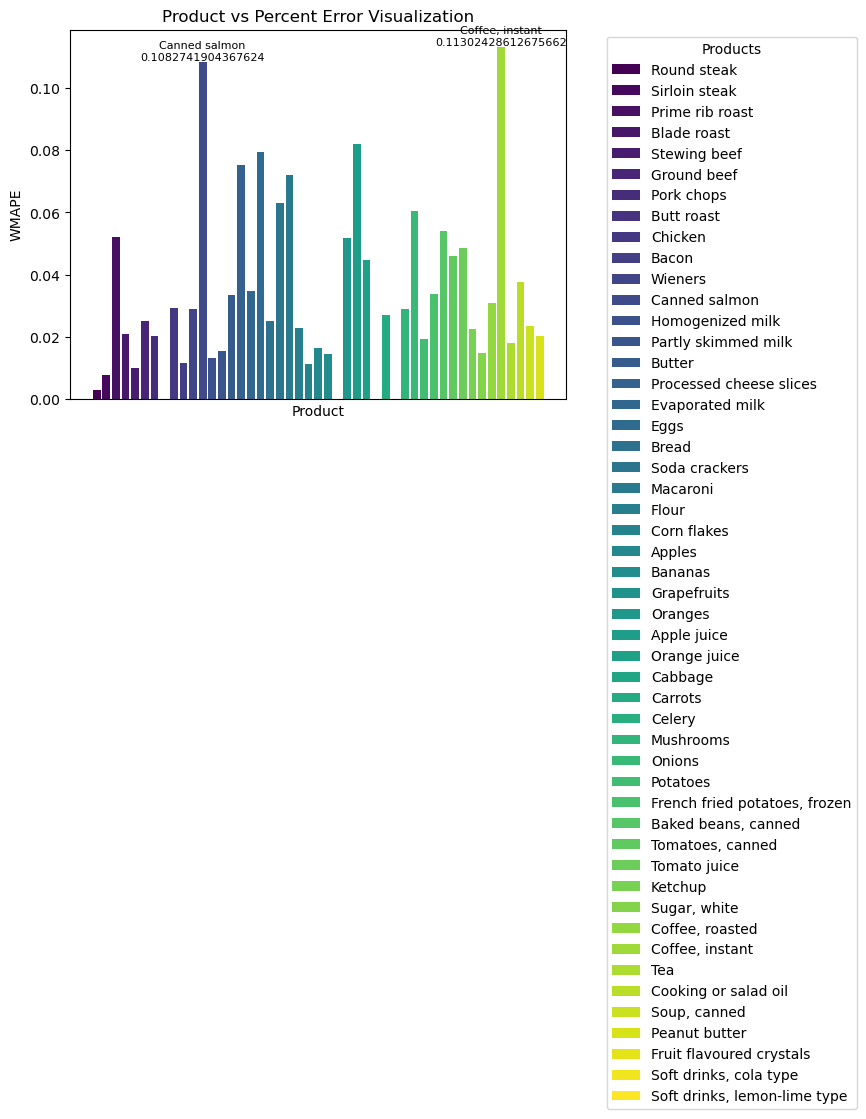

In [38]:
products = wmape_df['product'].unique()
colours = plt.cm.viridis(np.linspace(0, 1, len(products)))
threshold = 0.10 # this represents a threshold error of 10%

fig, ax = plt.subplots()

for i, product in enumerate(products):
    product_data = wmape_df[wmape_df['product'] == product]
    bars = ax.bar(product_data['product'], product_data['wmape'], color=colours[i], label = product)

    for bar, value in zip(bars, product_data['wmape']):
        if value > threshold:
            ax.text(bar.get_x() + bar.get_width() / 2, value, f'{product}\n{value}', ha='center', va='bottom', color='black', fontsize=8)

plt.xlabel('Product')
plt.ylabel('WMAPE')
plt.title('Product vs Percent Error Visualization')
plt.legend(title='Products', bbox_to_anchor=(1.6, 1), loc='upper right')
plt.xticks([]) # Remove category axis labels

plt.show()

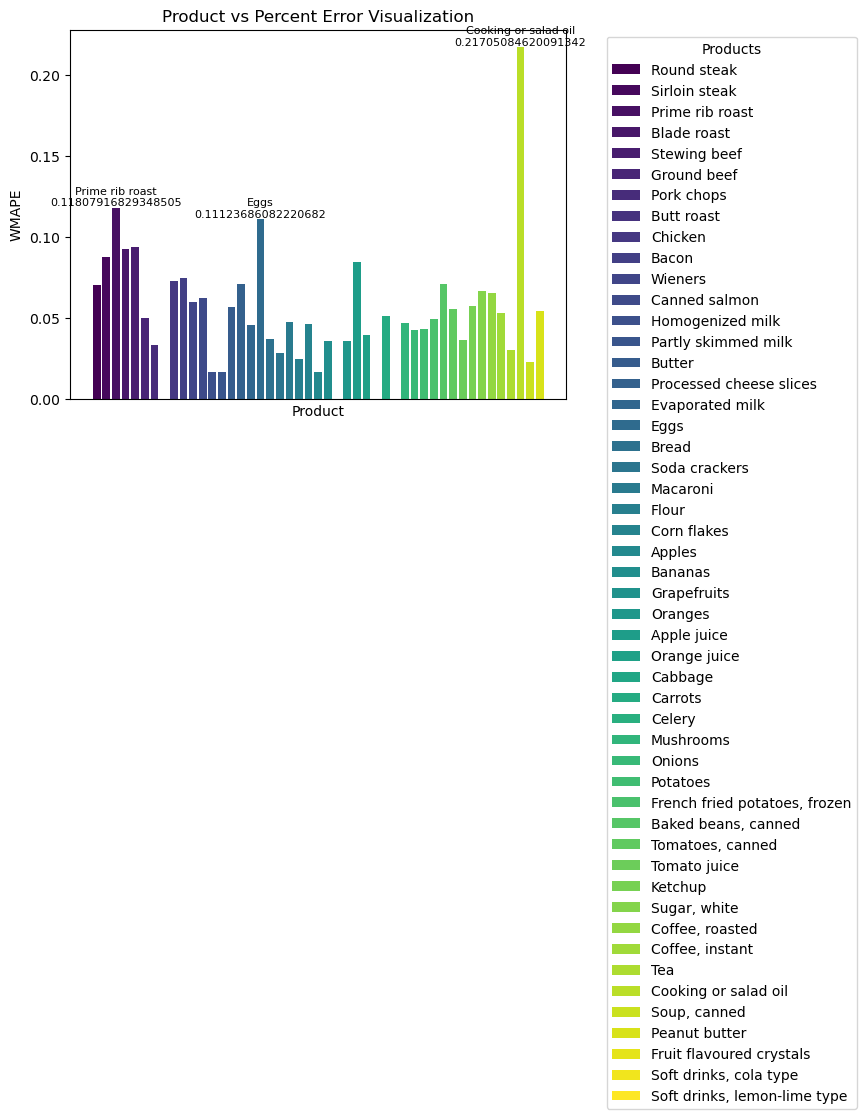

In [ ]:
# products = wmape_df['product'].unique()
# colours = plt.cm.viridis(np.linspace(0, 1, len(products)))
# threshold = 0.10 # this represents a threshold error of 10%

# fig, ax = plt.subplots()

# for i, product in enumerate(products):
#     product_data = wmape_df[wmape_df['product'] == product]
#     bars = ax.bar(product_data['product'], product_data['wmape'], color=colours[i], label = product)

#     for bar, value in zip(bars, product_data['wmape']):
#         if value > threshold:
#             ax.text(bar.get_x() + bar.get_width() / 2, value, f'{product}\n{value}', ha='center', va='bottom', color='black', fontsize=8)

# plt.xlabel('Product')
# plt.ylabel('WMAPE')
# plt.title('Product vs Percent Error Visualization')
# plt.legend(title='Products', bbox_to_anchor=(1.6, 1), loc='upper right')
# plt.xticks([]) # Remove category axis labels

# plt.show()

weighted mean absolute percentage error for Round steak: 0.003137165387760487
weighted mean absolute percentage error for Sirloin steak: 0.007901386207069247
weighted mean absolute percentage error for Prime rib roast: 0.052150968662549924
weighted mean absolute percentage error for Blade roast: 0.020859336485461358
weighted mean absolute percentage error for Stewing beef: 0.009945537602484
weighted mean absolute percentage error for Ground beef: 0.02516806493457661


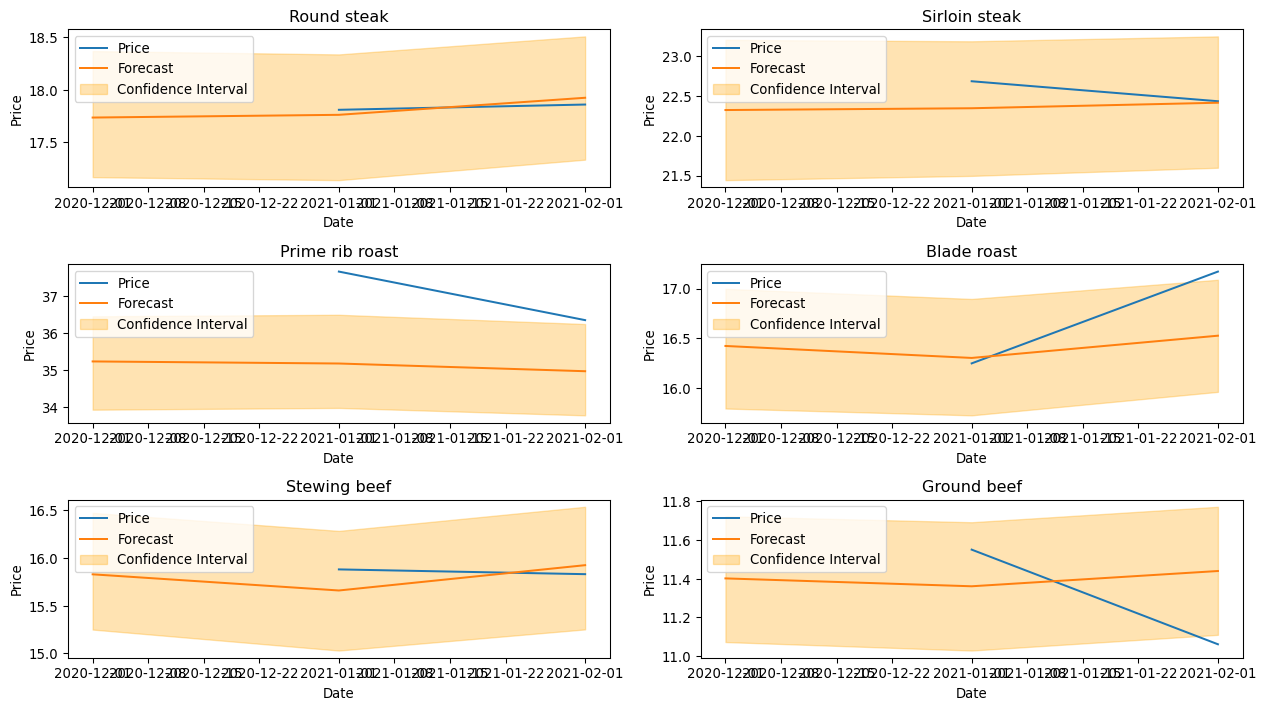

In [39]:
# plot the forecast for the first six items
fig, ax = plt.subplots(3, 2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_, product in enumerate(p['product'].unique()[0:6]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Round steak: 0.07063436479415956
weighted mean absolute percentage error for Sirloin steak: 0.08752981969045041
weighted mean absolute percentage error for Prime rib roast: 0.11807916829348505
weighted mean absolute percentage error for Blade roast: 0.09270654478285872
weighted mean absolute percentage error for Stewing beef: 0.09407558084977966
weighted mean absolute percentage error for Ground beef: 0.05008155616308703


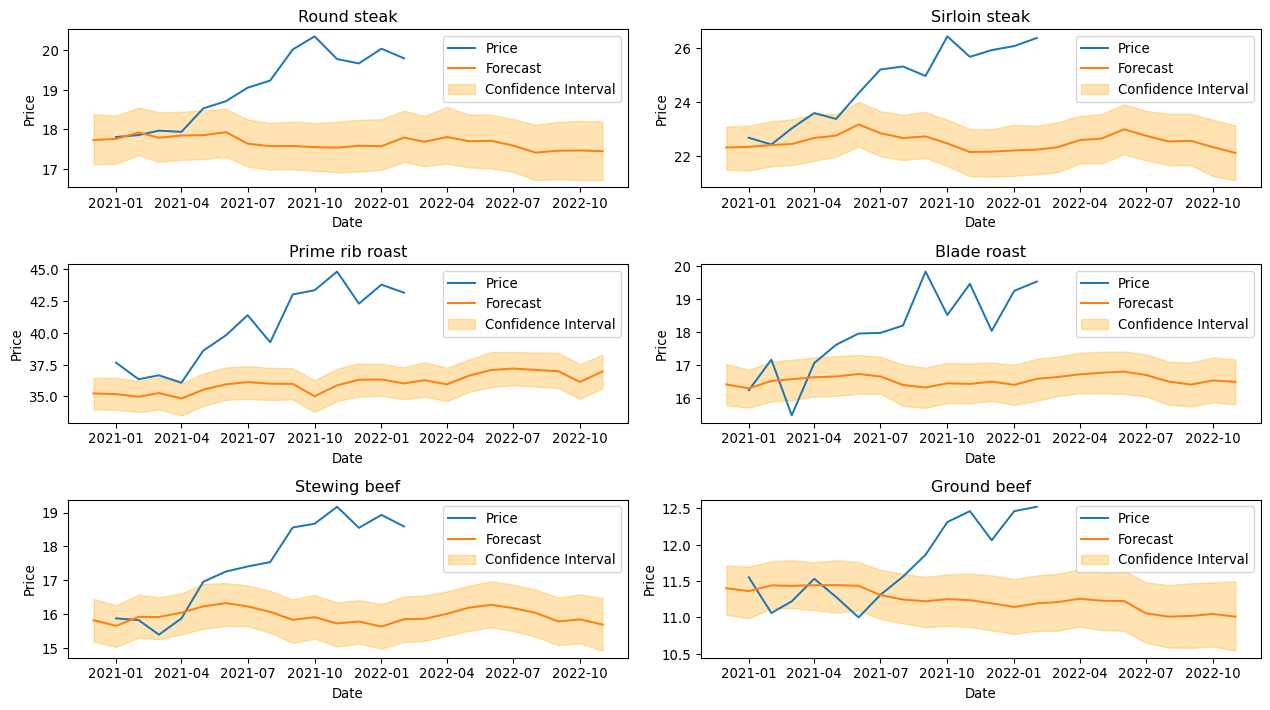

In [17]:
# plot the forecast for the first six items
fig, ax = plt.subplots(3, 2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_, product in enumerate(p['product'].unique()[0:6]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Pork chops: 0.033542651457619345
weighted mean absolute percentage error for Butt roast: nan
weighted mean absolute percentage error for Chicken: 0.07311846376911514
weighted mean absolute percentage error for Bacon: 0.07457907980512633
weighted mean absolute percentage error for Wieners: 0.060101184679964274
weighted mean absolute percentage error for Canned salmon: 0.0622990073123657


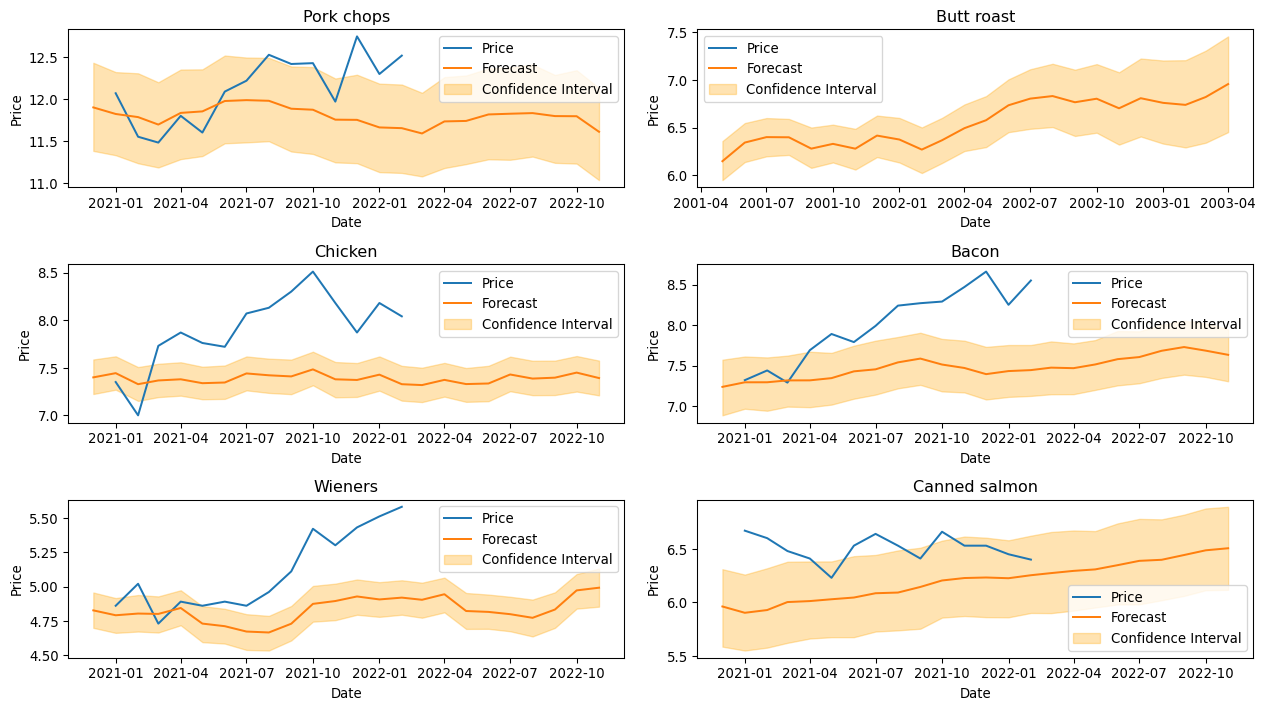

In [18]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(p['product'].unique()[6:12]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Homogenized milk: 0.01711588626822936
weighted mean absolute percentage error for Partly skimmed milk: 0.0170633564272346
weighted mean absolute percentage error for Butter: 0.05679465909981492
weighted mean absolute percentage error for Processed cheese slices: 0.070991017735028
weighted mean absolute percentage error for Evaporated milk: 0.04592396964318744
weighted mean absolute percentage error for Eggs: 0.11123686082220682


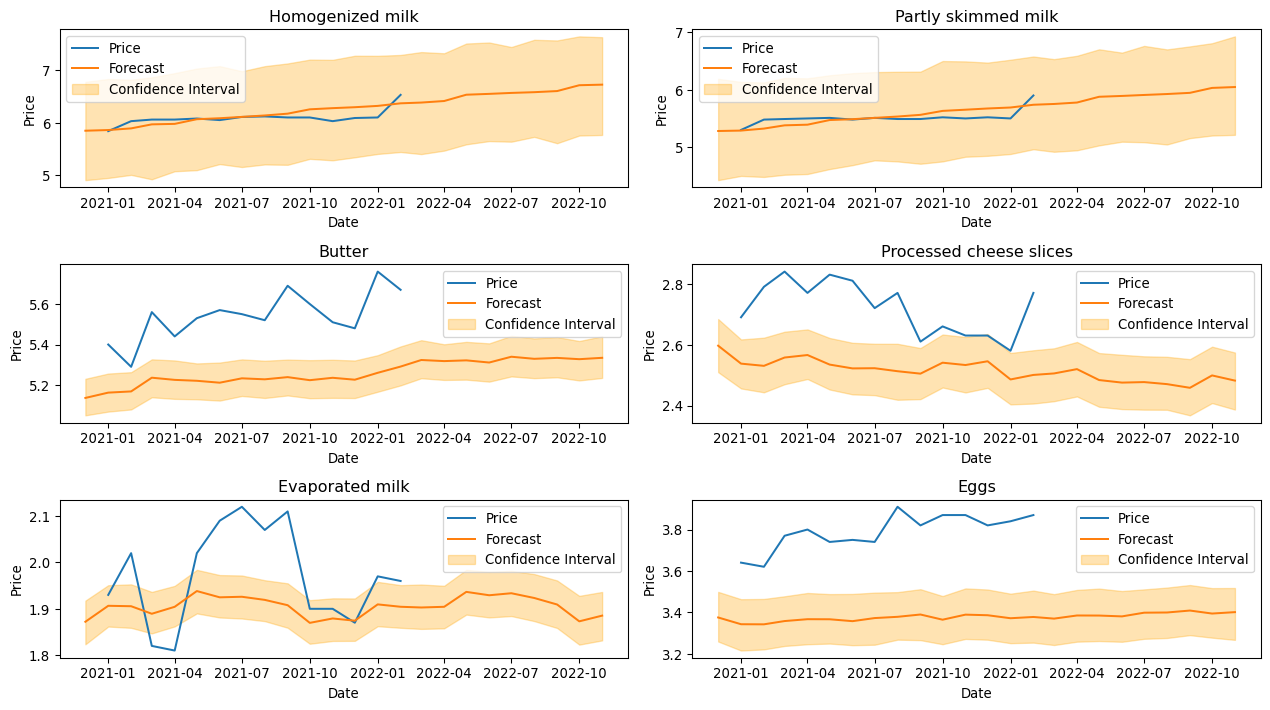

In [19]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(p['product'].unique()[12:18]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Bread: 0.03707243786597605
weighted mean absolute percentage error for Soda crackers: 0.028806060187893397
weighted mean absolute percentage error for Macaroni: 0.04757223926498135
weighted mean absolute percentage error for Flour: 0.025096128111939685
weighted mean absolute percentage error for Corn flakes: 0.04621855454105147
weighted mean absolute percentage error for Apples: 0.01690695315920176


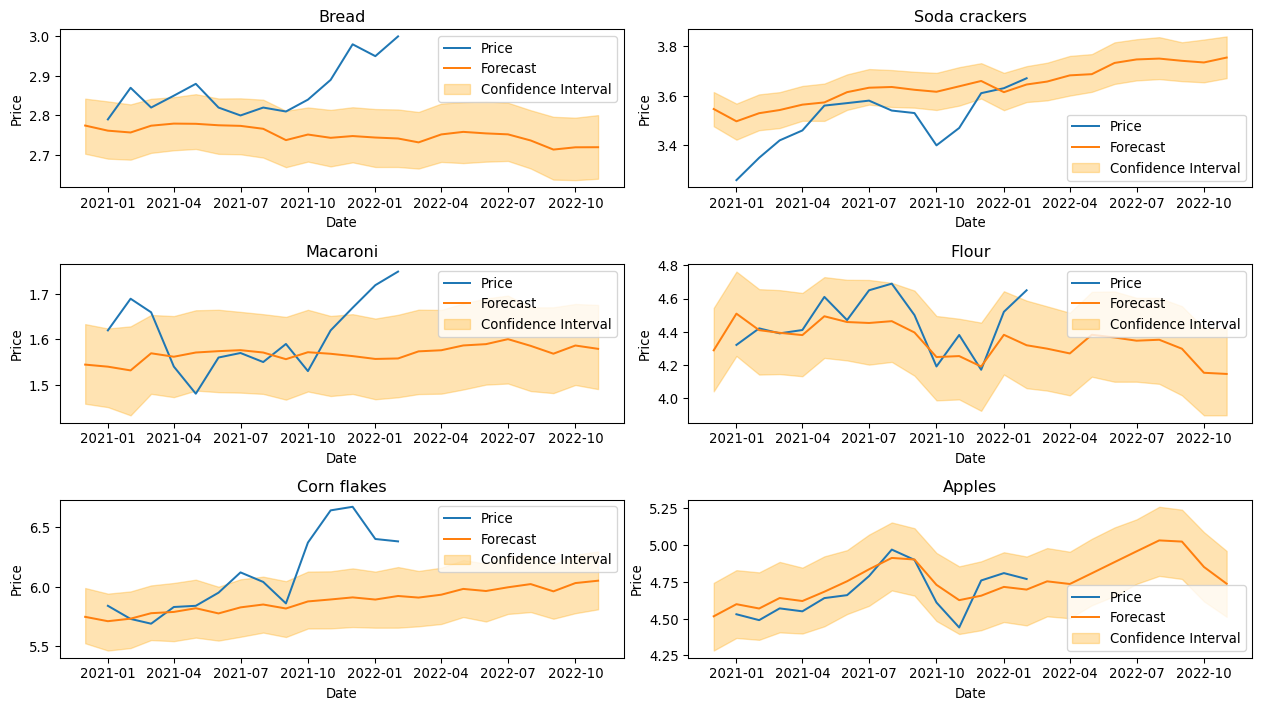

In [20]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(p['product'].unique()[18:24]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Bananas: 0.035685174842008574
weighted mean absolute percentage error for Grapefruits: nan
weighted mean absolute percentage error for Oranges: 0.03588912605669572
weighted mean absolute percentage error for Apple juice: 0.08437750291054064
weighted mean absolute percentage error for Orange juice: 0.03985940865975475
weighted mean absolute percentage error for Cabbage: nan


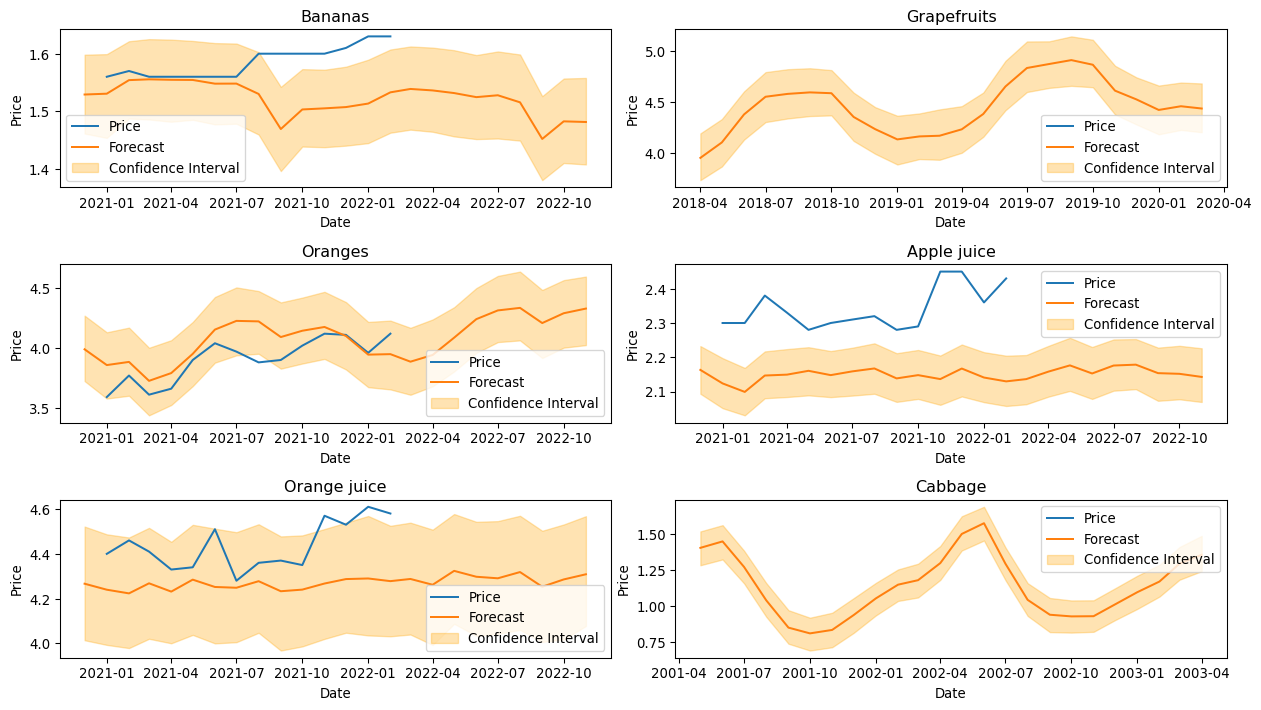

In [21]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(p['product'].unique()[24:30]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Carrots: 0.05163100523290105
weighted mean absolute percentage error for Celery: nan
weighted mean absolute percentage error for Mushrooms: 0.04684046185559203
weighted mean absolute percentage error for Onions: 0.04254009506553696
weighted mean absolute percentage error for Potatoes: 0.04349524445842647
weighted mean absolute percentage error for French fried potatoes, frozen: 0.04939118156121686


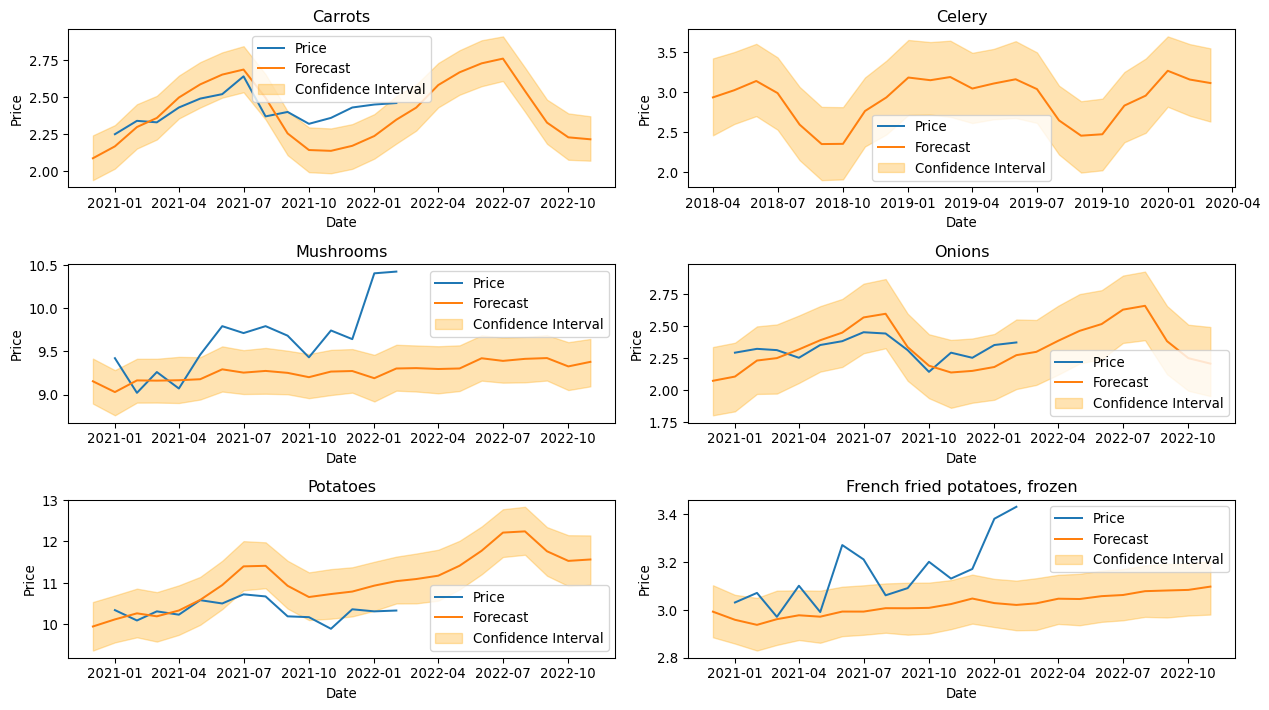

In [22]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(p['product'].unique()[30:36]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Baked beans, canned: 0.07132808141196696
weighted mean absolute percentage error for Tomatoes, canned: 0.05589448263172851
weighted mean absolute percentage error for Tomato juice: 0.03660374522542237
weighted mean absolute percentage error for Ketchup: 0.05733428778940274
weighted mean absolute percentage error for Sugar, white: 0.06653237434583714
weighted mean absolute percentage error for Coffee, roasted: 0.06534899639191356


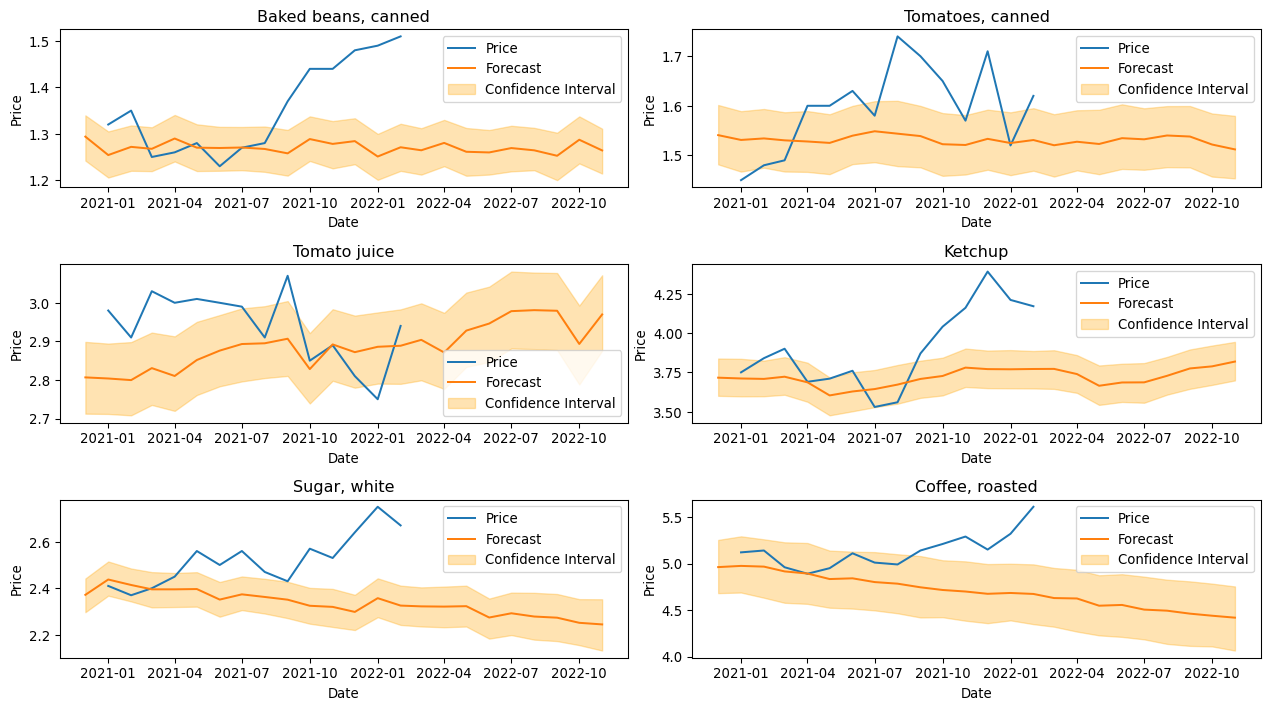

In [23]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(p['product'].unique()[36:42]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Coffee, instant: 0.0533476451380565
weighted mean absolute percentage error for Tea : 0.03044687084210731
weighted mean absolute percentage error for Cooking or salad oil: 0.21705084620091342
weighted mean absolute percentage error for Soup, canned: 0.023317413334867573
weighted mean absolute percentage error for Peanut butter: 0.05471554757858007
weighted mean absolute percentage error for Fruit flavoured crystals: nan


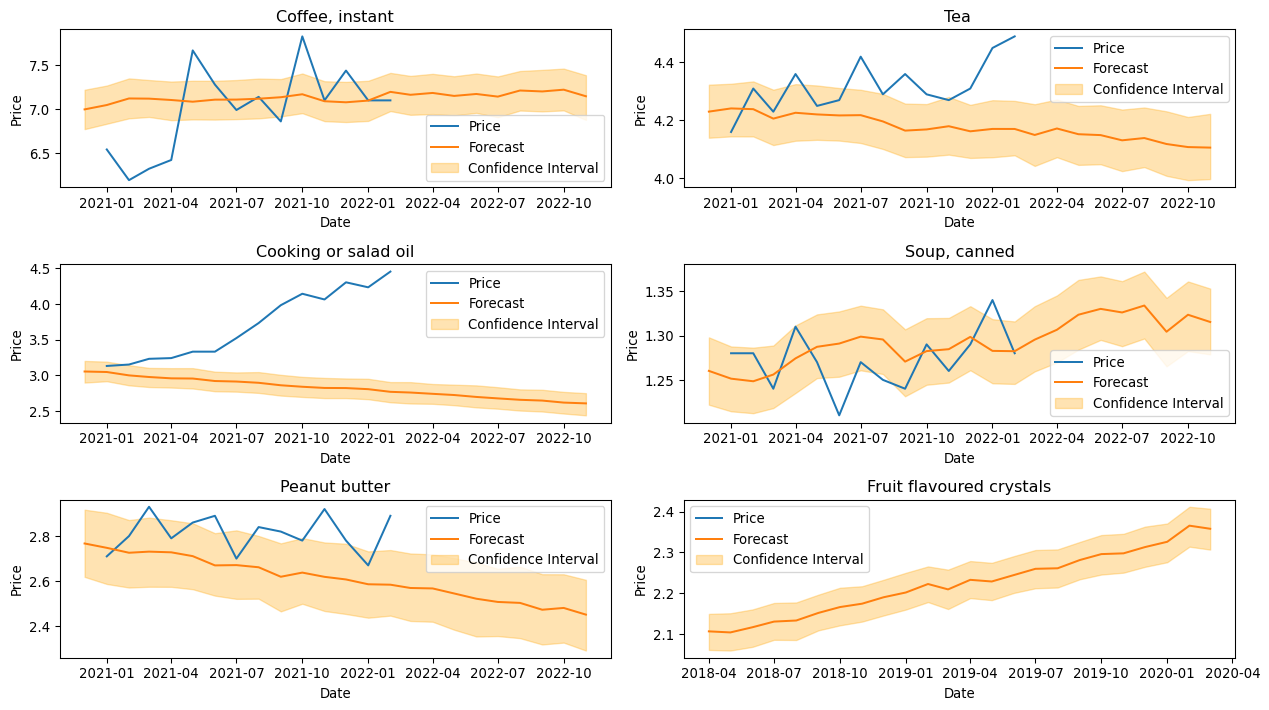

In [24]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(p['product'].unique()[42:48]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Soft drinks, cola type: nan
weighted mean absolute percentage error for Soft drinks, lemon-lime type: nan


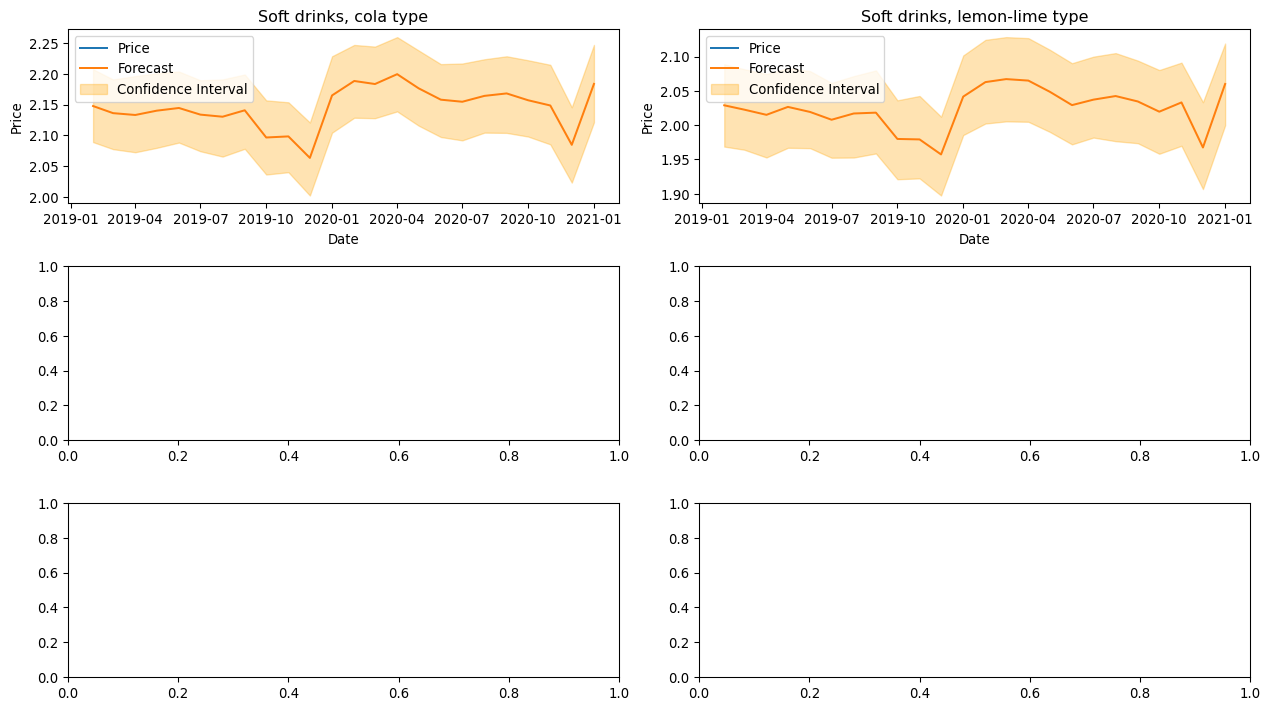

In [25]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(p['product'].unique()[48:54]):
    p_ = p.loc[p['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(p_['ds'], p_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(p_['ds'], p_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(p_['ds'], p_['yhat_lower'], p_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(p.loc[p['product'] == product]['y'], p.loc[p['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

### Save the models to JSON

In [ ]:
# save the Prophet models as JSON files
from prophet.serialize import model_to_json, model_from_json

...
m.fit(train_)

with open(f'prophet_{product}.json', 'w') as f:
    f.write(model_to_json(m))

future = m.make_future_dataframe(periods = 24, freq= 'M', include_history=False)
...

In [ ]:
# load the model
with open(f'prophet_{product}.json', 'r') as f:
    m = model_from_json(f.read())

### Troubleshooting & Testing

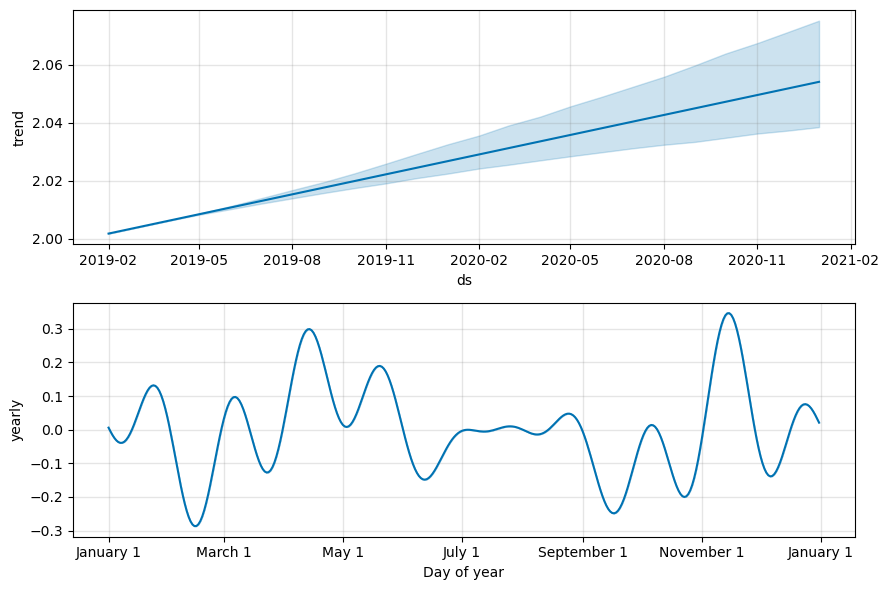

In [ ]:
m.plot_components(forecast)
plt.show()

In [ ]:
forecast['product']

0     Soft drinks, lemon-lime type
1     Soft drinks, lemon-lime type
2     Soft drinks, lemon-lime type
3     Soft drinks, lemon-lime type
4     Soft drinks, lemon-lime type
5     Soft drinks, lemon-lime type
6     Soft drinks, lemon-lime type
7     Soft drinks, lemon-lime type
8     Soft drinks, lemon-lime type
9     Soft drinks, lemon-lime type
10    Soft drinks, lemon-lime type
11    Soft drinks, lemon-lime type
12    Soft drinks, lemon-lime type
13    Soft drinks, lemon-lime type
14    Soft drinks, lemon-lime type
15    Soft drinks, lemon-lime type
16    Soft drinks, lemon-lime type
17    Soft drinks, lemon-lime type
18    Soft drinks, lemon-lime type
19    Soft drinks, lemon-lime type
20    Soft drinks, lemon-lime type
21    Soft drinks, lemon-lime type
22    Soft drinks, lemon-lime type
23    Soft drinks, lemon-lime type
Name: product, dtype: object

In [13]:
p = list()

product = 'Peanut butter'

print('product:', product)
# create datasets that contain only the rows from the original training and validation datasets that correspond with the current product being forecasted
train_ = train.loc[train['product'] == product]
valid_ = valid.loc[valid['product'] == product]

# create a Prophet object m with seasonality parameters
m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
# train the model with the product-specific training data
m.fit(train_)

# create a new dataframe that will contain the dates for the next 24 months after the end of the train_ dataset
future = m.make_future_dataframe(periods = 24, freq= 'M', include_history=False)
future

23:52:46 - cmdstanpy - INFO - Chain [1] start processing
23:52:46 - cmdstanpy - INFO - Chain [1] done processing


product: Peanut butter


,ds
0,2020-12-31
1,2021-01-31
2,2021-02-28
3,2021-03-31
4,2021-04-30
5,2021-05-31
6,2021-06-30
7,2021-07-31
8,2021-08-31
9,2021-09-30


In [14]:
# create new columns containing only month and year values to permit accurate joins
future['yyyy_mm'] = pd.to_datetime(future['ds']).dt.strftime('%Y-%m')
future

,ds,yyyy_mm
0,2020-12-31,2020-12
1,2021-01-31,2021-01
2,2021-02-28,2021-02
3,2021-03-31,2021-03
4,2021-04-30,2021-04
5,2021-05-31,2021-05
6,2021-06-30,2021-06
7,2021-07-31,2021-07
8,2021-08-31,2021-08
9,2021-09-30,2021-09


In [15]:
valid_['yyyy_mm'] = pd.to_datetime(valid_['ds']).dt.strftime('%Y-%m')
valid_

C:\Users\maddy\AppData\Local\Temp\ipykernel_19296\3971671459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_['yyyy_mm'] = pd.to_datetime(valid_['ds']).dt.strftime('%Y-%m')


,location,vectorid,y,product,unit_quantity,unit,category,ds,yyyy_mm
15094,Canada,v735207,2.71,Peanut butter,500.0,grams,Protein,2021-01-01,2021-01
15137,Canada,v735207,2.80,Peanut butter,500.0,grams,Protein,2021-02-01,2021-02
15180,Canada,v735207,2.93,Peanut butter,500.0,grams,Protein,2021-03-01,2021-03
15223,Canada,v735207,2.79,Peanut butter,500.0,grams,Protein,2021-04-01,2021-04
15266,Canada,v735207,2.86,Peanut butter,500.0,grams,Protein,2021-05-01,2021-05
15309,Canada,v735207,2.89,Peanut butter,500.0,grams,Protein,2021-06-01,2021-06
15352,Canada,v735207,2.70,Peanut butter,500.0,grams,Protein,2021-07-01,2021-07
15395,Canada,v735207,2.84,Peanut butter,500.0,grams,Protein,2021-08-01,2021-08
15438,Canada,v735207,2.82,Peanut butter,500.0,grams,Protein,2021-09-01,2021-09
15481,Canada,v735207,2.78,Peanut butter,500.0,grams,Protein,2021-10-01,2021-10


In [16]:
# drop old 'ds' columns
future.drop(columns=['ds'], inplace=True)
valid_.drop(columns=['ds'], inplace=True)
# rename new 'yyyy_mm' columns to 'ds'
future.rename(columns={'yyyy_mm':'ds'}, inplace=True)
valid_.rename(columns={'yyyy_mm':'ds'}, inplace=True)

C:\Users\maddy\AppData\Local\Temp\ipykernel_19296\741862858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_.drop(columns=['ds'], inplace=True)
C:\Users\maddy\AppData\Local\Temp\ipykernel_19296\741862858.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_.rename(columns={'yyyy_mm':'ds'}, inplace=True)


In [17]:
future

,ds
0,2020-12
1,2021-01
2,2021-02
3,2021-03
4,2021-04
5,2021-05
6,2021-06
7,2021-07
8,2021-08
9,2021-09


In [18]:
valid_

,location,vectorid,y,product,unit_quantity,unit,category,ds
15094,Canada,v735207,2.71,Peanut butter,500.0,grams,Protein,2021-01
15137,Canada,v735207,2.80,Peanut butter,500.0,grams,Protein,2021-02
15180,Canada,v735207,2.93,Peanut butter,500.0,grams,Protein,2021-03
15223,Canada,v735207,2.79,Peanut butter,500.0,grams,Protein,2021-04
15266,Canada,v735207,2.86,Peanut butter,500.0,grams,Protein,2021-05
15309,Canada,v735207,2.89,Peanut butter,500.0,grams,Protein,2021-06
15352,Canada,v735207,2.70,Peanut butter,500.0,grams,Protein,2021-07
15395,Canada,v735207,2.84,Peanut butter,500.0,grams,Protein,2021-08
15438,Canada,v735207,2.82,Peanut butter,500.0,grams,Protein,2021-09
15481,Canada,v735207,2.78,Peanut butter,500.0,grams,Protein,2021-10


In [19]:
# merge future data with valid_ data
future = future.merge(valid_[['ds','product', 'y']], on=['ds'], how='left')

future

,ds,product,y
0,2020-12,NaN,NaN
1,2021-01,Peanut butter,2.71
2,2021-02,Peanut butter,2.80
3,2021-03,Peanut butter,2.93
4,2021-04,Peanut butter,2.79
5,2021-05,Peanut butter,2.86
6,2021-06,Peanut butter,2.89
7,2021-07,Peanut butter,2.70
8,2021-08,Peanut butter,2.84
9,2021-09,Peanut butter,2.82


In [20]:
# create a dataframe to contain the predicted values for each date in the {future} dataframe
forecast = m.predict(future)
# add a 'product' column to the forecast dataframe containing predicted values
# this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
forecast['product'] = product
# append the product prediction to the list of stored predictions
p.append(forecast[['ds', 'yhat', 'product']])

In [21]:
p = pd.concat(p, ignore_index=True)
# clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
p['yhat'] = p['yhat'].clip(lower=0)
# create new 'yyyy_mm' column for {valid} dataframe
valid['yyyy_mm'] = pd.to_datetime(valid['ds']).dt.strftime('%Y-%m')
# drop old 'ds' column
valid.drop(columns=['ds'], inplace=True)
# rename new 'yyyy_mm' column to 'ds'
valid.rename(columns={'yyyy_mm':'ds'}, inplace=True)
# convert {valid} 'ds' column to datetime
valid['ds'] = pd.to_datetime(valid['ds'])
# merge prediction {p} dataframe with validation {valid} dataframe to compare values 
p = p.merge(valid, on=['ds', 'product'], how='left')


C:\Users\maddy\AppData\Local\Temp\ipykernel_19296\1898691107.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['yyyy_mm'] = pd.to_datetime(valid['ds']).dt.strftime('%Y-%m')
C:\Users\maddy\AppData\Local\Temp\ipykernel_19296\1898691107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.drop(columns=['ds'], inplace=True)
C:\Users\maddy\AppData\Local\Temp\ipykernel_19296\1898691107.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [22]:
p

,ds,yhat,product,location,vectorid,y,unit_quantity,unit,category
0,2020-12-01,2.767161,Peanut butter,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,2.747842,Peanut butter,Canada,v735207,2.71,500.0,grams,Protein
2,2021-02-01,2.726021,Peanut butter,Canada,v735207,2.80,500.0,grams,Protein
3,2021-03-01,2.731004,Peanut butter,Canada,v735207,2.93,500.0,grams,Protein
4,2021-04-01,2.727908,Peanut butter,Canada,v735207,2.79,500.0,grams,Protein
5,2021-05-01,2.711012,Peanut butter,Canada,v735207,2.86,500.0,grams,Protein
6,2021-06-01,2.669902,Peanut butter,Canada,v735207,2.89,500.0,grams,Protein
7,2021-07-01,2.671169,Peanut butter,Canada,v735207,2.70,500.0,grams,Protein
8,2021-08-01,2.661636,Peanut butter,Canada,v735207,2.84,500.0,grams,Protein
9,2021-09-01,2.619501,Peanut butter,Canada,v735207,2.82,500.0,grams,Protein


In [23]:
print(p.dtypes)

ds               datetime64[ns]
yhat                    float64
product                  object
location                 object
vectorid                 object
y                       float64
unit_quantity           float64
unit                     object
category                 object
dtype: object


In [24]:
print(valid.dtypes)

location                 object
vectorid                 object
y                       float64
product                  object
unit_quantity           float64
unit                     object
category                 object
ds               datetime64[ns]
dtype: object


In [25]:
wmape(p['y'], p['yhat'])

0.05471554757858007